# Introduction to Machine Learning in Finance and Insurance (Spring 2025)
# Project 2: Insurance Claim Prediction

### Team members: Neil Aellen, Akos Arendas,Yannick Hänggi, Denis Künzi

---

## Housekeeping

In [115]:
#!pip install tensorflow keras
#!pip install keras-tuner tensorflow keras

In [116]:
# Import necessary modules to run this analysis
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import PoissonRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

import warnings

import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.losses import Poisson
from tensorflow import keras
from tensorflow.keras import layers
import keras_tuner as kt
from tensorflow.keras.regularizers import l2

# --- Metric functions ---
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

# Set style for better plots
plt.style.use('default')
sns.set_palette("husl")

# Fix random seed for reproducibility
np.random.seed(4)
tf.random.set_seed(4)
random.seed(4)

# import os
# print(os.getcwd())


## Exercise 1: Data Exploration

In [2]:
# Load data
df_raw = pd.read_csv("./p2_insurance_claim_prediction/data/raw/freMTPL2freq.csv",sep=";", decimal=',')

In [3]:
# Display numerical info on the dataset
print("\nDataset Info:")
display(df_raw.info())

print("\nDescriptive statistics:")
display(df_raw.describe(include="all"))


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 678007 entries, 0 to 678006
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   VehPower    678007 non-null  int64  
 1   VehAge      678007 non-null  int64  
 2   DrivAge     678007 non-null  int64  
 3   BonusMalus  678007 non-null  int64  
 4   VehBrand    678007 non-null  object 
 5   VehGas      678007 non-null  object 
 6   Density     678007 non-null  int64  
 7   Region      678007 non-null  object 
 8   Exposure    678007 non-null  float64
 9   ClaimNb     678007 non-null  int64  
dtypes: float64(1), int64(6), object(3)
memory usage: 51.7+ MB


None


Descriptive statistics:


VehPower         VehAge        DrivAge     BonusMalus VehBrand  \
count   678007.000000  678007.000000  678007.000000  678007.000000   678007   
unique            NaN            NaN            NaN            NaN       11   
top               NaN            NaN            NaN            NaN      B12   
freq              NaN            NaN            NaN            NaN   166024   
mean         6.454653       7.044218      45.499061      59.761588      NaN   
std          2.050902       5.666235      14.137492      15.636700      NaN   
min          4.000000       0.000000      18.000000      50.000000      NaN   
25%          5.000000       2.000000      34.000000      50.000000      NaN   
50%          6.000000       6.000000      44.000000      50.000000      NaN   
75%          7.000000      11.000000      55.000000      64.000000      NaN   
max         15.000000     100.000000     100.000000     230.000000      NaN   

         VehGas        Density  Region       Exposure        ClaimNb  
count    678007  678007.000000  678007  678007.000000  678007.000000  
unique        2            NaN      22            NaN            NaN  
top     Regular            NaN     R24            NaN            NaN  
freq     345871            NaN  160601            NaN            NaN  
mean        NaN    1792.430975     NaN       0.528547       0.038913  
std         NaN    3958.663031     NaN       0.364081       0.204752  
min         NaN       1.000000     NaN       0.002732       0.000000  
25%         NaN      92.000000     NaN       0.180000       0.000000  
50%         NaN     393.000000     NaN       0.490000       0.000000  
75%         NaN    1658.000000     NaN       0.990000       0.000000  
max         NaN   27000.000000     NaN       1.000000       5.000000

The dataset at hand is comprised of 678'000 individual car insurance policies and for each policy we have 10 variables.
We can see that there are no missing values and the ranges and data types align with the exercise description.
Next, before we create our target variable y_i = ClaimNb_i / Exposure_i we want to ensure that there are no policies with zero or near-zero exposure.

In [48]:
# Filter out zero exposure cases and calculate claim frequency
df_clean = df_raw[df_raw['Exposure'] > 1e-6].copy()
df_clean['ClaimFrequency'] = df_clean['ClaimNb'] / df_clean['Exposure']

print(f"Filtered dataset shape: {df_clean.shape}")
print(f"Removed {len(df_raw) - len(df_clean)} records with zero/near-zero exposure")

Filtered dataset shape: (678007, 11)
Removed 0 records with zero/near-zero exposure


We can see that there are no zero or near-zero exposures which would hamper with our analysis and hence can start with the exploratory data analysis. At first, we will use a pairplot showing the relationship between the features and the claim frequency.

/tmp/ipykernel_1109/3767607626.py:41: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  axes[1, 0].plot(age_freq['DrivAge'], age_freq['mean'], 'b-', linewidth=2, color='skyblue')


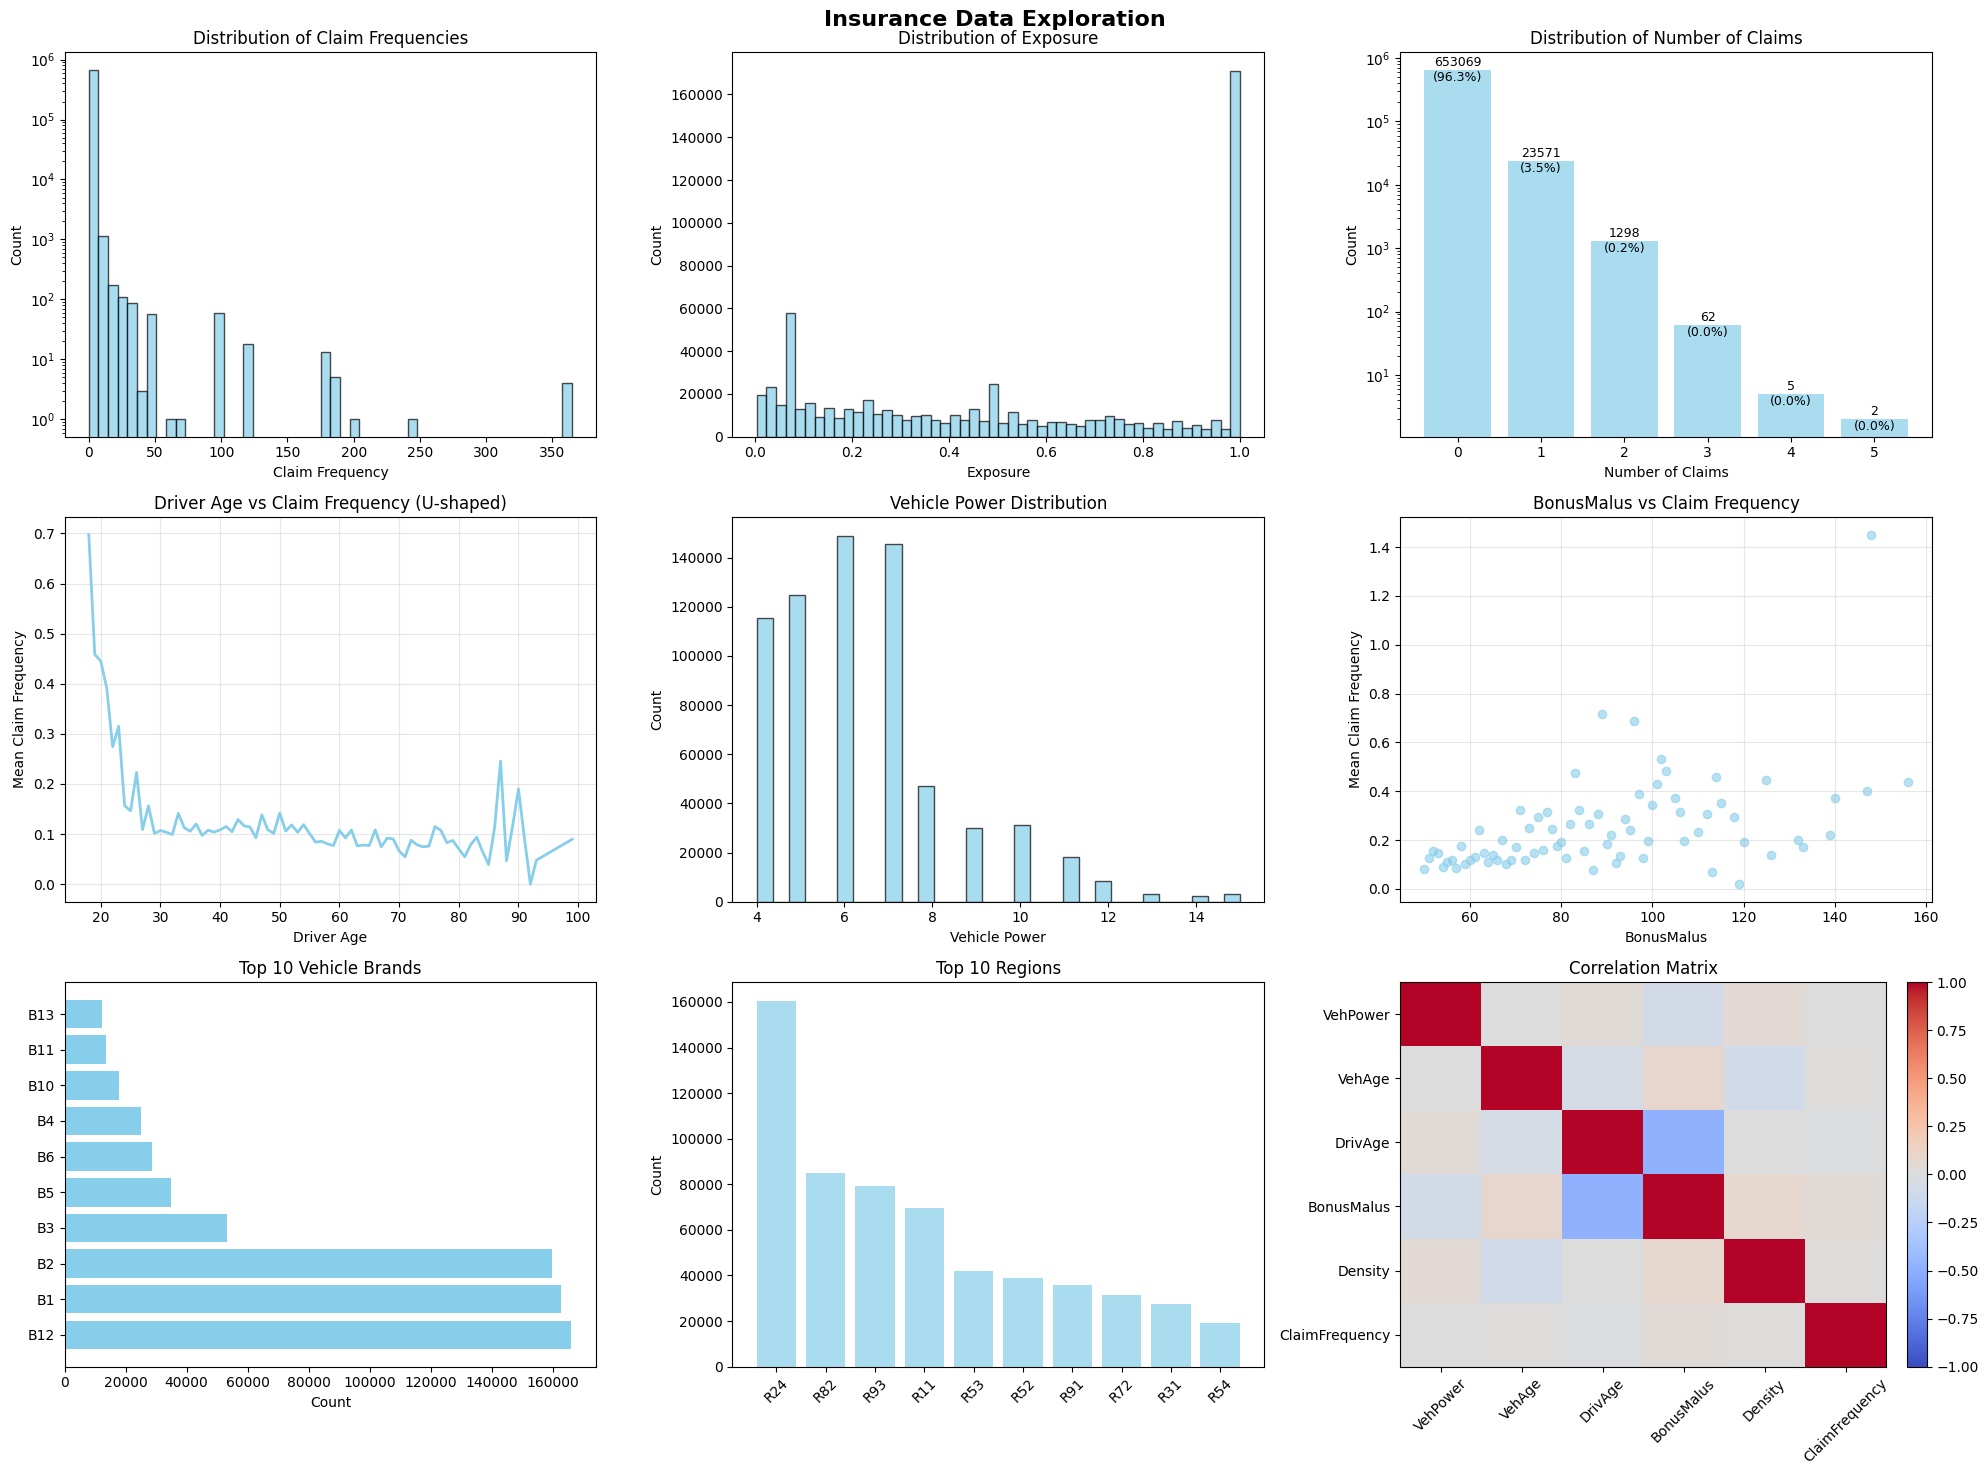


Claim Frequency Statistics:
Mean: 0.117907
Std:  2.002881
Min:  0.000000
Max:  365.000000
% of zero claims: 96.32%

General Claim Statistics:
Total Number of Claims: 26383
Total Exposure: 358358.8054629836
Average Claim Frequency (calculated): 0.0736


In [49]:
# Create comprehensive visualization
fig, axes = plt.subplots(3, 3, figsize=(20, 15))
fig.suptitle('Insurance Data Exploration', fontsize=16, fontweight='bold')

# Plot 1: Claim frequency distribution
axes[0, 0].hist(df_clean['ClaimFrequency'], bins=50, alpha=0.7, edgecolor='black', color='skyblue')
axes[0, 0].set_title('Distribution of Claim Frequencies')
axes[0, 0].set_xlabel('Claim Frequency')
axes[0, 0].set_ylabel('Count')
axes[0, 0].set_yscale('log')

# Plot 2: Exposure distribution
axes[0, 1].hist(df_clean['Exposure'], bins=50, alpha=0.7, edgecolor='black', color='skyblue')
axes[0, 1].set_title('Distribution of Exposure')
axes[0, 1].set_xlabel('Exposure')
axes[0, 1].set_ylabel('Count')


# Plot 3: Number of claims distribution
claim_counts = df_clean['ClaimNb'].value_counts().sort_index()
bars = axes[0, 2].bar(claim_counts.index, claim_counts.values, alpha=0.7, color='skyblue')
axes[0, 2].set_title('Distribution of Number of Claims')
axes[0, 2].set_xlabel('Number of Claims')
axes[0, 2].set_ylabel('Count')
axes[0, 2].set_yscale('log')

# Add count and percentage above bars
total = claim_counts.values.sum()
for bar, count in zip(bars, claim_counts.values):
    percent = 100 * count / total
    axes[0, 2].text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() * 0.6,
        f'{count}\n({percent:.1f}%)',
        ha='center', va='bottom', fontsize=9
    )

# Plot 4: Driver Age vs Claim Frequency (U-shaped relationship)
age_freq = df_clean.groupby('DrivAge')['ClaimFrequency'].agg(['mean', 'count']).reset_index()
age_freq = age_freq[age_freq['count'] >= 50]  # Filter ages with sufficient data
axes[1, 0].plot(age_freq['DrivAge'], age_freq['mean'], 'b-', linewidth=2, color='skyblue')
axes[1, 0].set_title('Driver Age vs Claim Frequency (U-shaped)')
axes[1, 0].set_xlabel('Driver Age')
axes[1, 0].set_ylabel('Mean Claim Frequency')
axes[1, 0].grid(True, alpha=0.3)

# Plot 5: Vehicle Power distribution
axes[1, 1].hist(df_clean['VehPower'], bins=30, alpha=0.7, edgecolor='black', color='skyblue')
axes[1, 1].set_title('Vehicle Power Distribution')
axes[1, 1].set_xlabel('Vehicle Power')
axes[1, 1].set_ylabel('Count')

# Plot 6: BonusMalus vs Claim Frequency
bonus_freq = df_clean.groupby('BonusMalus')['ClaimFrequency'].agg(['mean', 'count']).reset_index()
bonus_freq = bonus_freq[bonus_freq['count'] >= 20]
axes[1, 2].scatter(bonus_freq['BonusMalus'], bonus_freq['mean'], alpha=0.6, color='skyblue')
axes[1, 2].set_title('BonusMalus vs Claim Frequency')
axes[1, 2].set_xlabel('BonusMalus')
axes[1, 2].set_ylabel('Mean Claim Frequency')
axes[1, 2].grid(True, alpha=0.3)

# Plot 7: Vehicle Brand (top 10)
top_brands = df_clean['VehBrand'].value_counts().head(10)
axes[2, 0].barh(range(len(top_brands)), top_brands.values, color='skyblue')
axes[2, 0].set_yticks(range(len(top_brands)))
axes[2, 0].set_yticklabels(top_brands.index)
axes[2, 0].set_title('Top 10 Vehicle Brands')
axes[2, 0].set_xlabel('Count')

# Plot 8: Region distribution (top 10)
top_regions = df_clean['Region'].value_counts().head(10)
axes[2, 1].bar(range(len(top_regions)), top_regions.values, alpha=0.7, color='skyblue')
axes[2, 1].set_xticks(range(len(top_regions)))
axes[2, 1].set_xticklabels(top_regions.index, rotation=45)
axes[2, 1].set_title('Top 10 Regions')
axes[2, 1].set_ylabel('Count')

# Plot 9: Correlation matrix of numerical features
numerical_cols = ['VehPower', 'VehAge', 'DrivAge', 'BonusMalus', 'Density', 'ClaimFrequency']
corr_matrix = df_clean[numerical_cols].corr()
im = axes[2, 2].imshow(corr_matrix, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
axes[2, 2].set_xticks(range(len(numerical_cols)))
axes[2, 2].set_yticks(range(len(numerical_cols)))
axes[2, 2].set_xticklabels(numerical_cols, rotation=45)
axes[2, 2].set_yticklabels(numerical_cols)
axes[2, 2].set_title('Correlation Matrix')

# Add colorbar
plt.colorbar(im, ax=axes[2, 2], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

# Summary statistics
print("\nClaim Frequency Statistics:")
print(f"Mean: {df_clean['ClaimFrequency'].mean():.6f}")
print(f"Std:  {df_clean['ClaimFrequency'].std():.6f}")
print(f"Min:  {df_clean['ClaimFrequency'].min():.6f}")
print(f"Max:  {df_clean['ClaimFrequency'].max():.6f}")
print(f"% of zero claims: {(df_clean['ClaimFrequency'] == 0).mean() * 100:.2f}%")
print("\nGeneral Claim Statistics:")
print(f"Total Number of Claims: {df_clean['ClaimNb'].sum()}")
print(f"Total Exposure: {df_clean['Exposure'].sum()}")
print(f"Average Claim Frequency (calculated): {df_clean['ClaimNb'].sum() / df_clean['Exposure'].sum():.4f}")

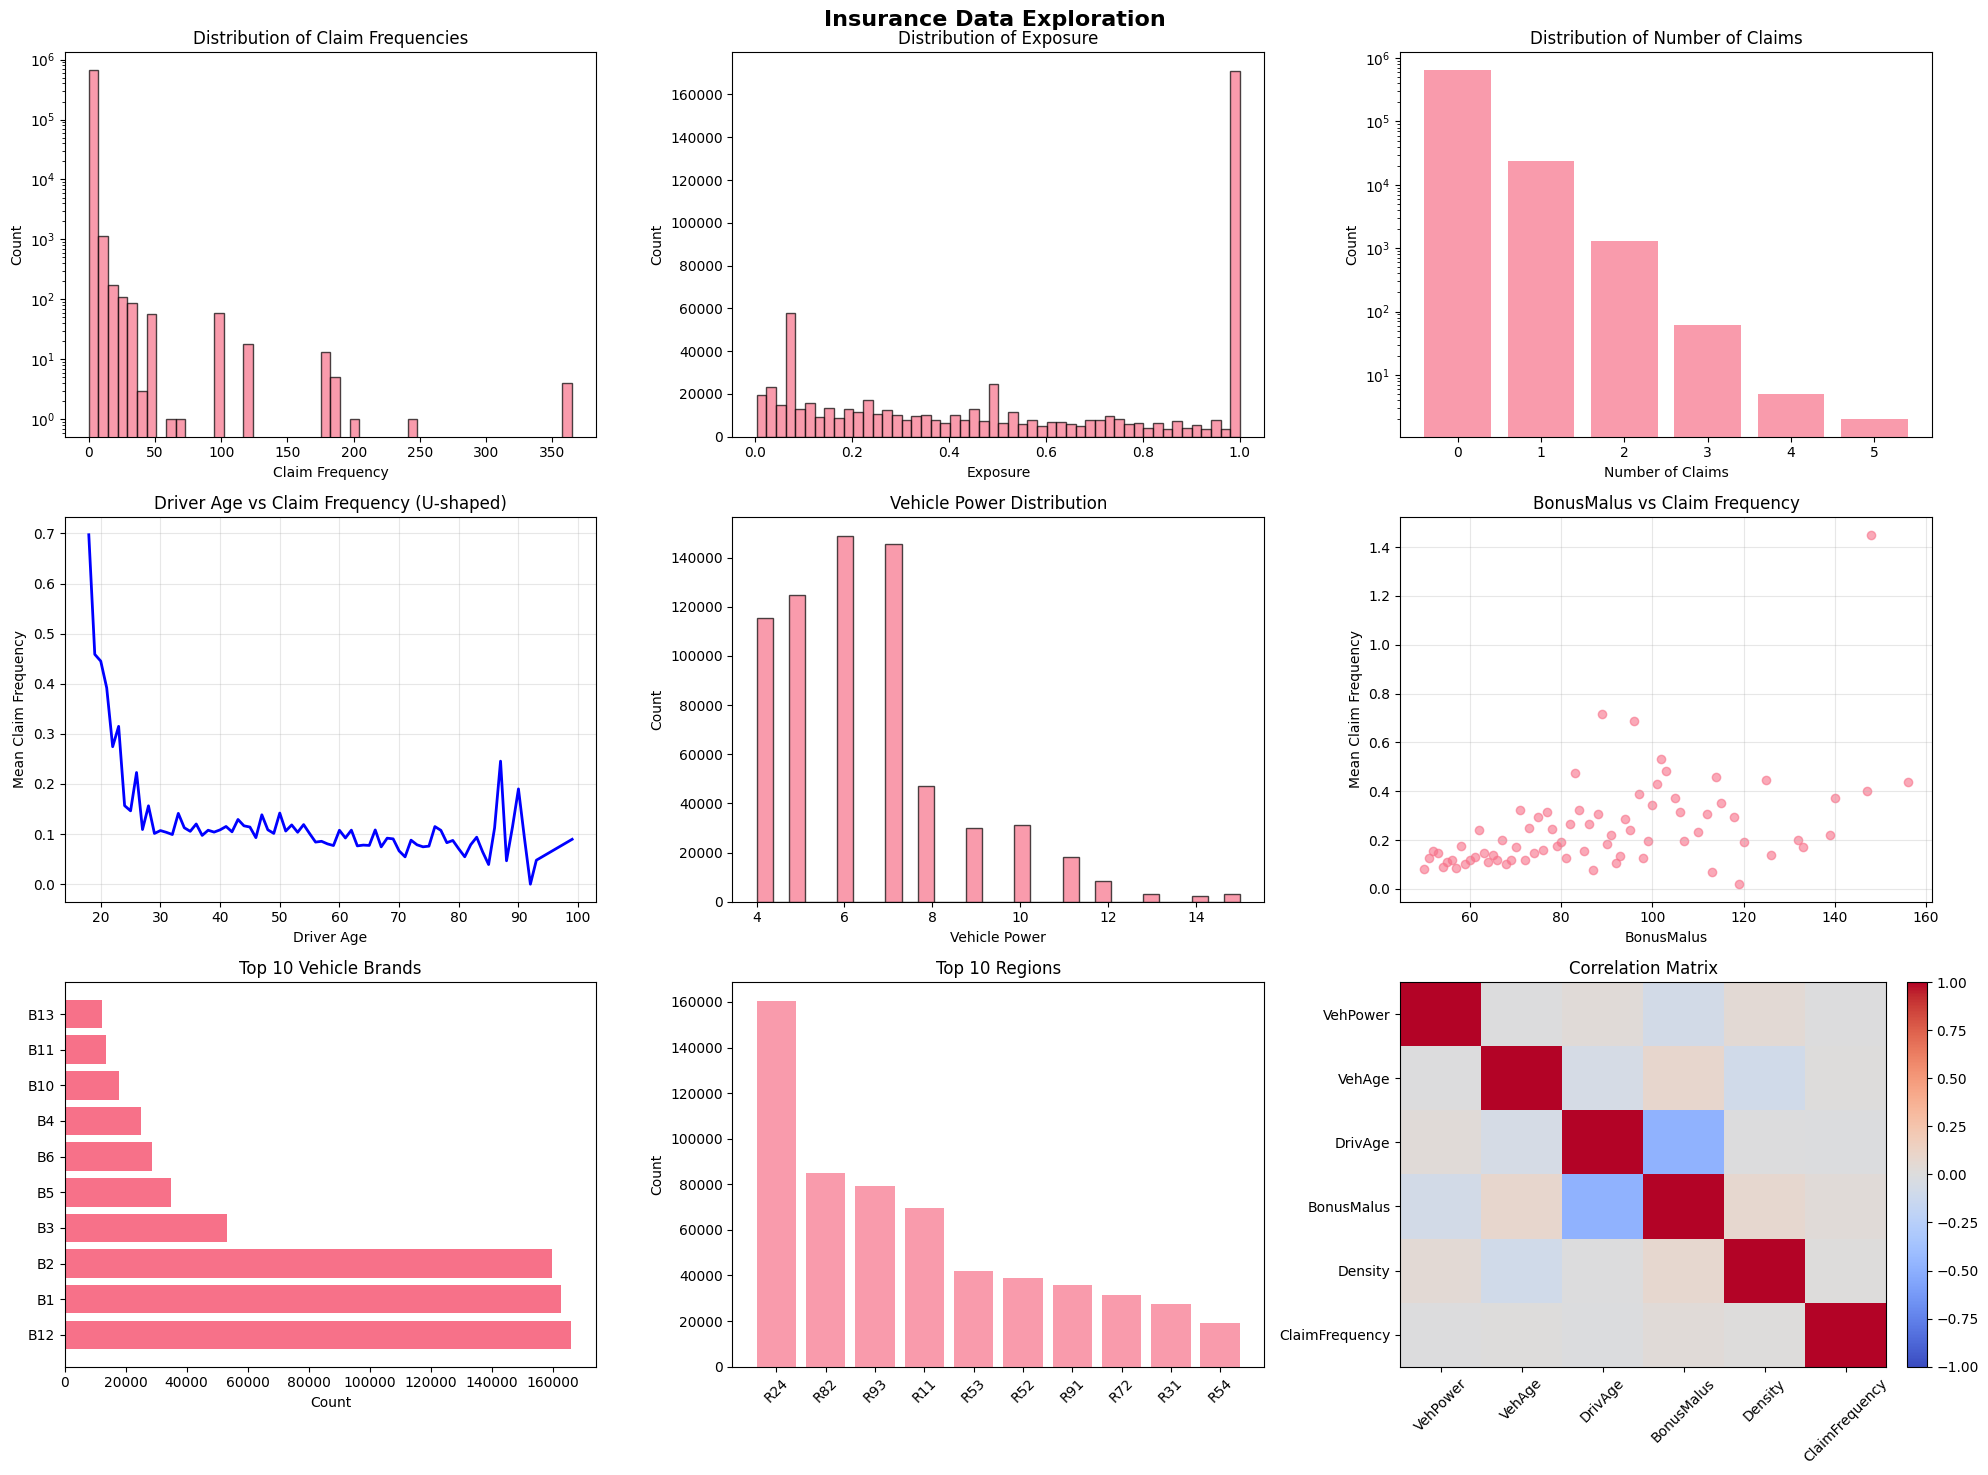


Claim Frequency Statistics:
Mean: 0.117907
Std:  2.002881
Min:  0.000000
Max:  365.000000
% of zero claims: 96.32%


In [5]:
# Create comprehensive visualization
fig, axes = plt.subplots(3, 3, figsize=(20, 15))
fig.suptitle('Insurance Data Exploration', fontsize=16, fontweight='bold')

# Plot 1: Claim frequency distribution
axes[0, 0].hist(df_clean['ClaimFrequency'], bins=50, alpha=0.7, edgecolor='black')
axes[0, 0].set_title('Distribution of Claim Frequencies')
axes[0, 0].set_xlabel('Claim Frequency')
axes[0, 0].set_ylabel('Count')
axes[0, 0].set_yscale('log')

# Plot 2: Exposure distribution
axes[0, 1].hist(df_clean['Exposure'], bins=50, alpha=0.7, edgecolor='black')
axes[0, 1].set_title('Distribution of Exposure')
axes[0, 1].set_xlabel('Exposure')
axes[0, 1].set_ylabel('Count')

# Plot 3: Number of claims distribution
claim_counts = df_clean['ClaimNb'].value_counts().sort_index()
axes[0, 2].bar(claim_counts.index, claim_counts.values, alpha=0.7)
axes[0, 2].set_title('Distribution of Number of Claims')
axes[0, 2].set_xlabel('Number of Claims')
axes[0, 2].set_ylabel('Count')
axes[0, 2].set_yscale('log')

# Plot 4: Driver Age vs Claim Frequency (U-shaped relationship)
age_freq = df_clean.groupby('DrivAge')['ClaimFrequency'].agg(['mean', 'count']).reset_index()
age_freq = age_freq[age_freq['count'] >= 50]  # Filter ages with sufficient data
axes[1, 0].plot(age_freq['DrivAge'], age_freq['mean'], 'b-', linewidth=2)
axes[1, 0].set_title('Driver Age vs Claim Frequency (U-shaped)')
axes[1, 0].set_xlabel('Driver Age')
axes[1, 0].set_ylabel('Mean Claim Frequency')
axes[1, 0].grid(True, alpha=0.3)

# Plot 5: Vehicle Power distribution
axes[1, 1].hist(df_clean['VehPower'], bins=30, alpha=0.7, edgecolor='black')
axes[1, 1].set_title('Vehicle Power Distribution')
axes[1, 1].set_xlabel('Vehicle Power')
axes[1, 1].set_ylabel('Count')

# Plot 6: BonusMalus vs Claim Frequency
bonus_freq = df_clean.groupby('BonusMalus')['ClaimFrequency'].agg(['mean', 'count']).reset_index()
bonus_freq = bonus_freq[bonus_freq['count'] >= 20]
axes[1, 2].scatter(bonus_freq['BonusMalus'], bonus_freq['mean'], alpha=0.6)
axes[1, 2].set_title('BonusMalus vs Claim Frequency')
axes[1, 2].set_xlabel('BonusMalus')
axes[1, 2].set_ylabel('Mean Claim Frequency')
axes[1, 2].grid(True, alpha=0.3)

# Plot 7: Vehicle Brand (top 10)
top_brands = df_clean['VehBrand'].value_counts().head(10)
axes[2, 0].barh(range(len(top_brands)), top_brands.values)
axes[2, 0].set_yticks(range(len(top_brands)))
axes[2, 0].set_yticklabels(top_brands.index)
axes[2, 0].set_title('Top 10 Vehicle Brands')
axes[2, 0].set_xlabel('Count')

# Plot 8: Region distribution (top 10)
top_regions = df_clean['Region'].value_counts().head(10)
axes[2, 1].bar(range(len(top_regions)), top_regions.values, alpha=0.7)
axes[2, 1].set_xticks(range(len(top_regions)))
axes[2, 1].set_xticklabels(top_regions.index, rotation=45)
axes[2, 1].set_title('Top 10 Regions')
axes[2, 1].set_ylabel('Count')

# Plot 9: Correlation matrix of numerical features
numerical_cols = ['VehPower', 'VehAge', 'DrivAge', 'BonusMalus', 'Density', 'ClaimFrequency']
corr_matrix = df_clean[numerical_cols].corr()
im = axes[2, 2].imshow(corr_matrix, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
axes[2, 2].set_xticks(range(len(numerical_cols)))
axes[2, 2].set_yticks(range(len(numerical_cols)))
axes[2, 2].set_xticklabels(numerical_cols, rotation=45)
axes[2, 2].set_yticklabels(numerical_cols)
axes[2, 2].set_title('Correlation Matrix')

# Add colorbar
plt.colorbar(im, ax=axes[2, 2], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

# Summary statistics
print("\nClaim Frequency Statistics:")
print(f"Mean: {df_clean['ClaimFrequency'].mean():.6f}")
print(f"Std:  {df_clean['ClaimFrequency'].std():.6f}")
print(f"Min:  {df_clean['ClaimFrequency'].min():.6f}")
print(f"Max:  {df_clean['ClaimFrequency'].max():.6f}")
print(f"% of zero claims: {(df_clean['ClaimFrequency'] == 0).mean() * 100:.2f}%")


Preparing categorical features for visualization...
✓ Categorical features prepared

Generating pairplot for numerical features...
✓ Cleaned numerical data shape: (678007, 6)


<Figure size 1800x1500 with 0 Axes>

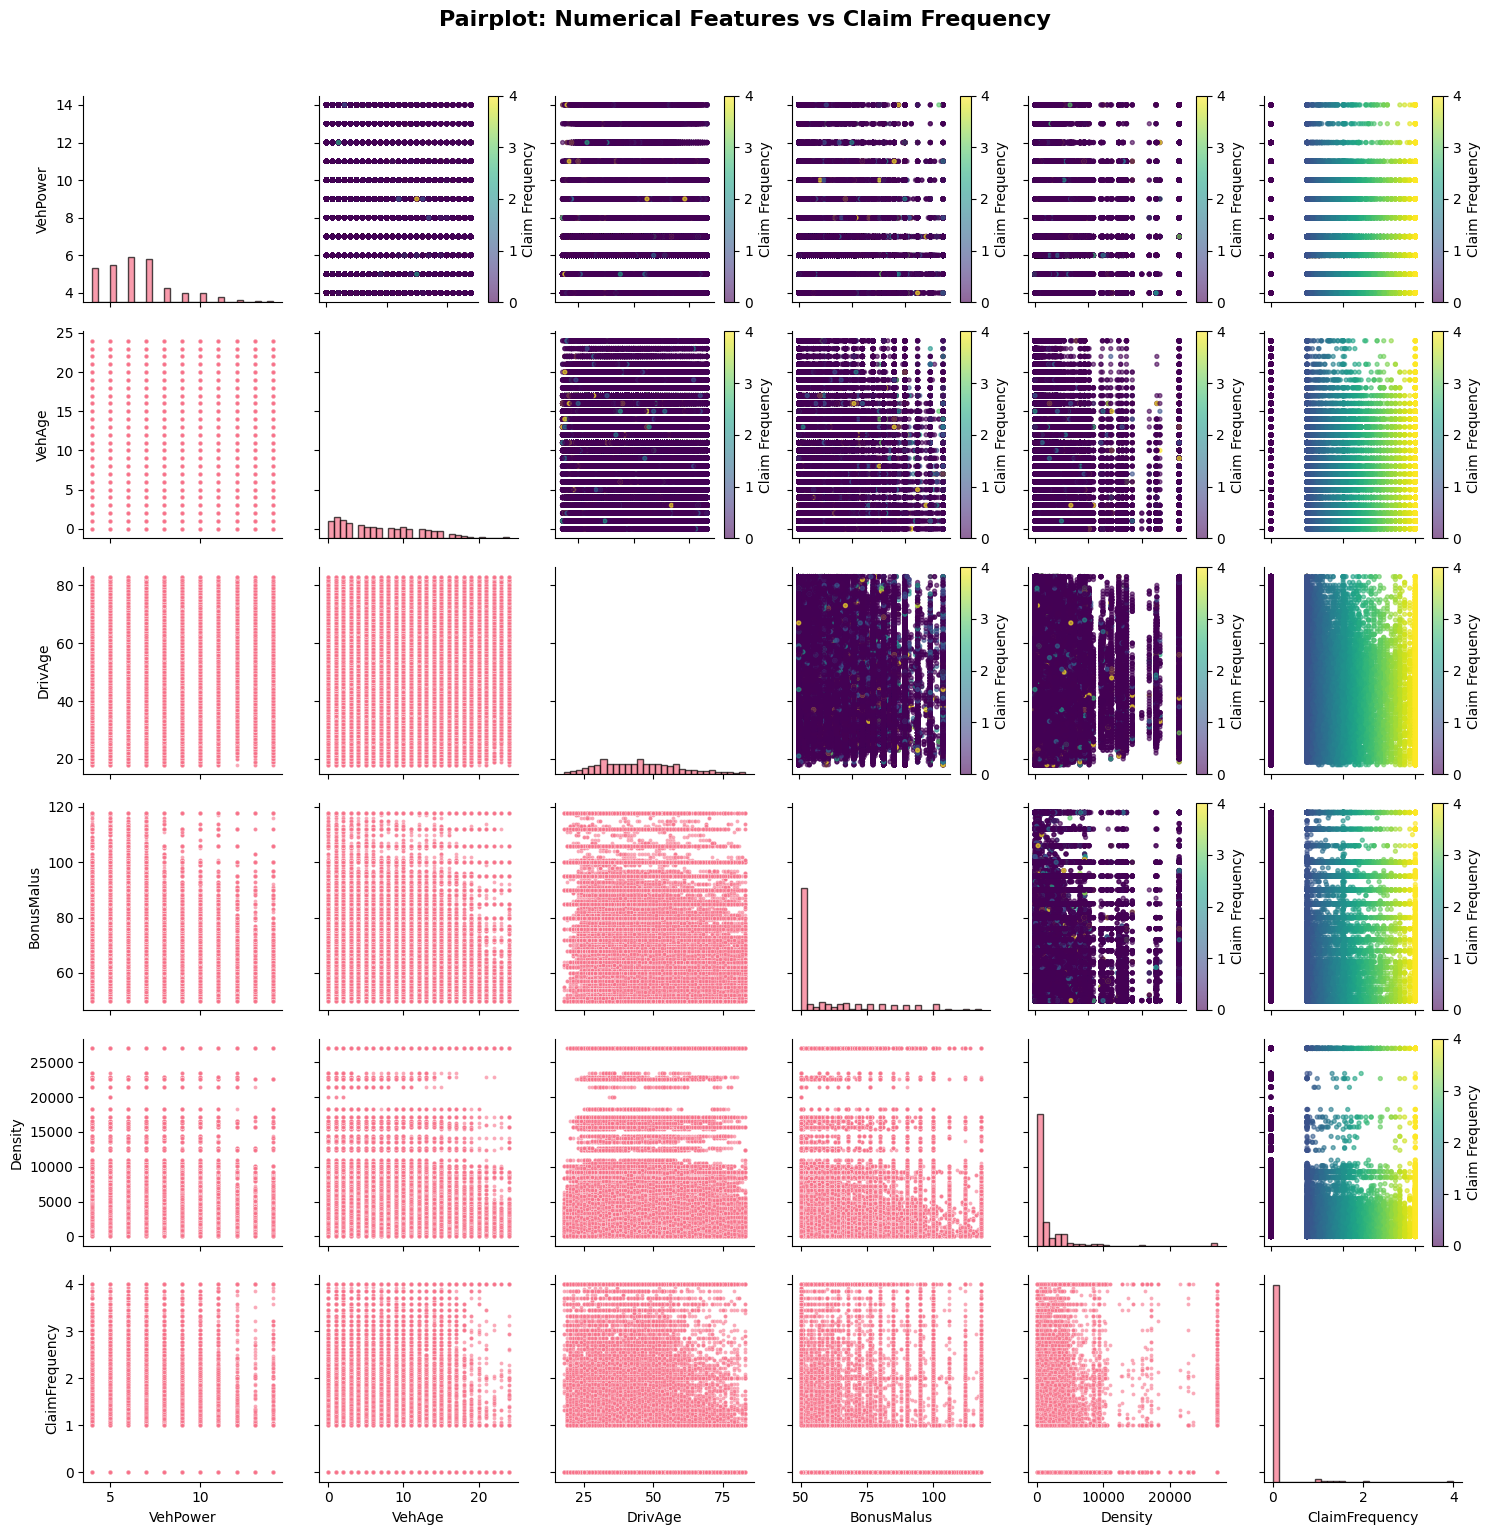


Generating focused pairplot with Claim Frequency as target...


<Figure size 1500x1200 with 0 Axes>

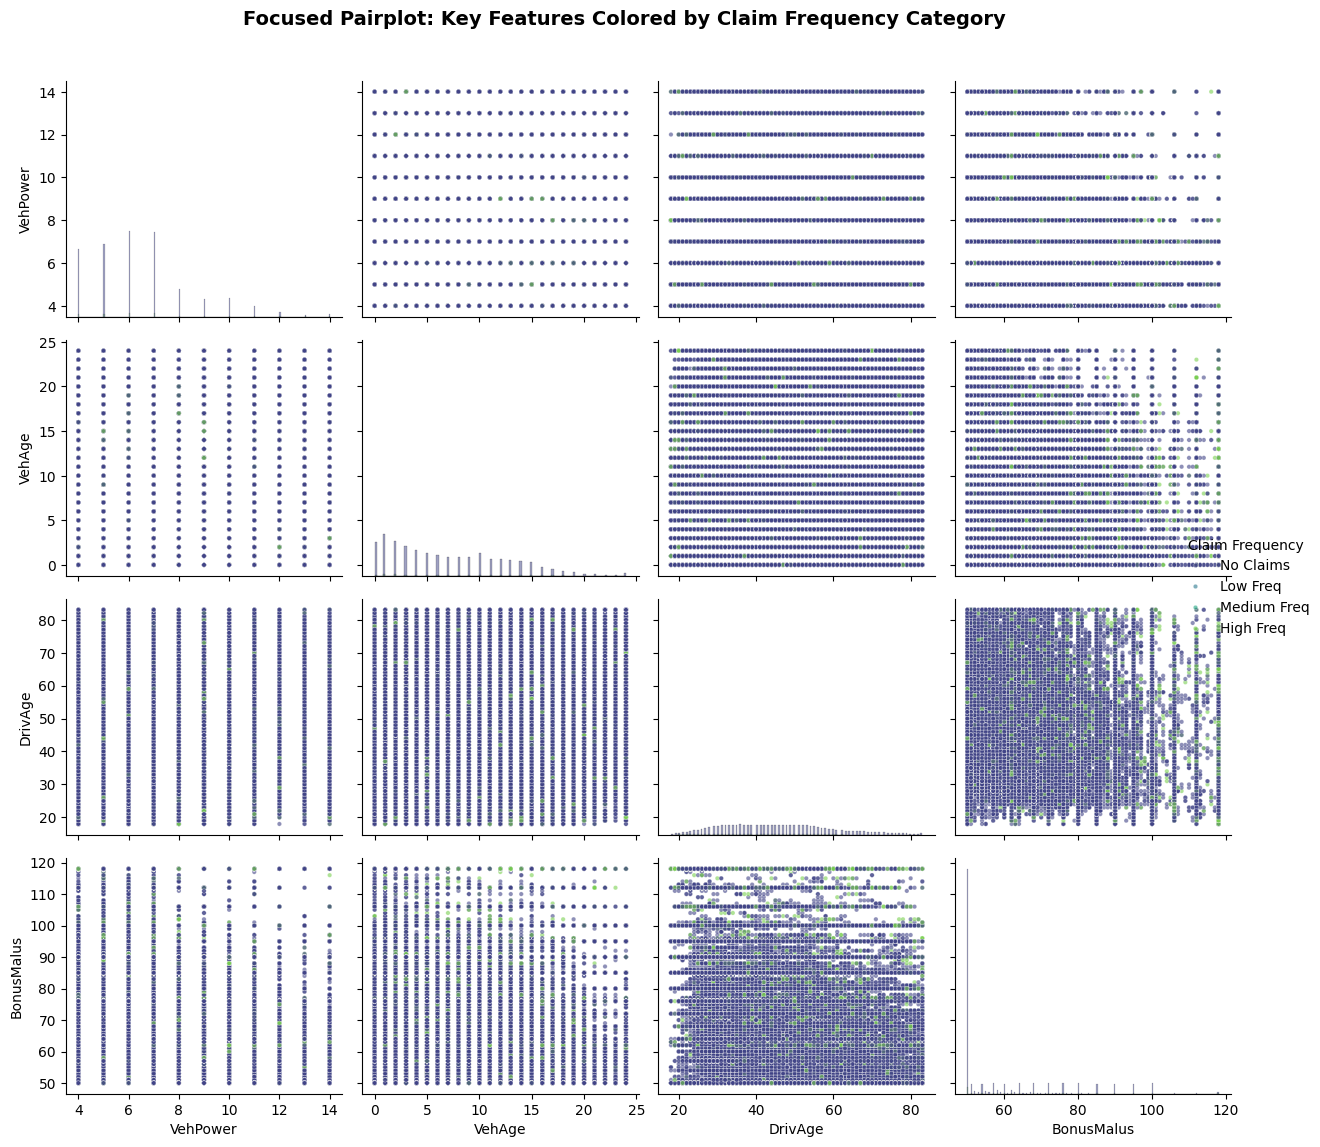


Generating individual feature vs claim frequency plots...


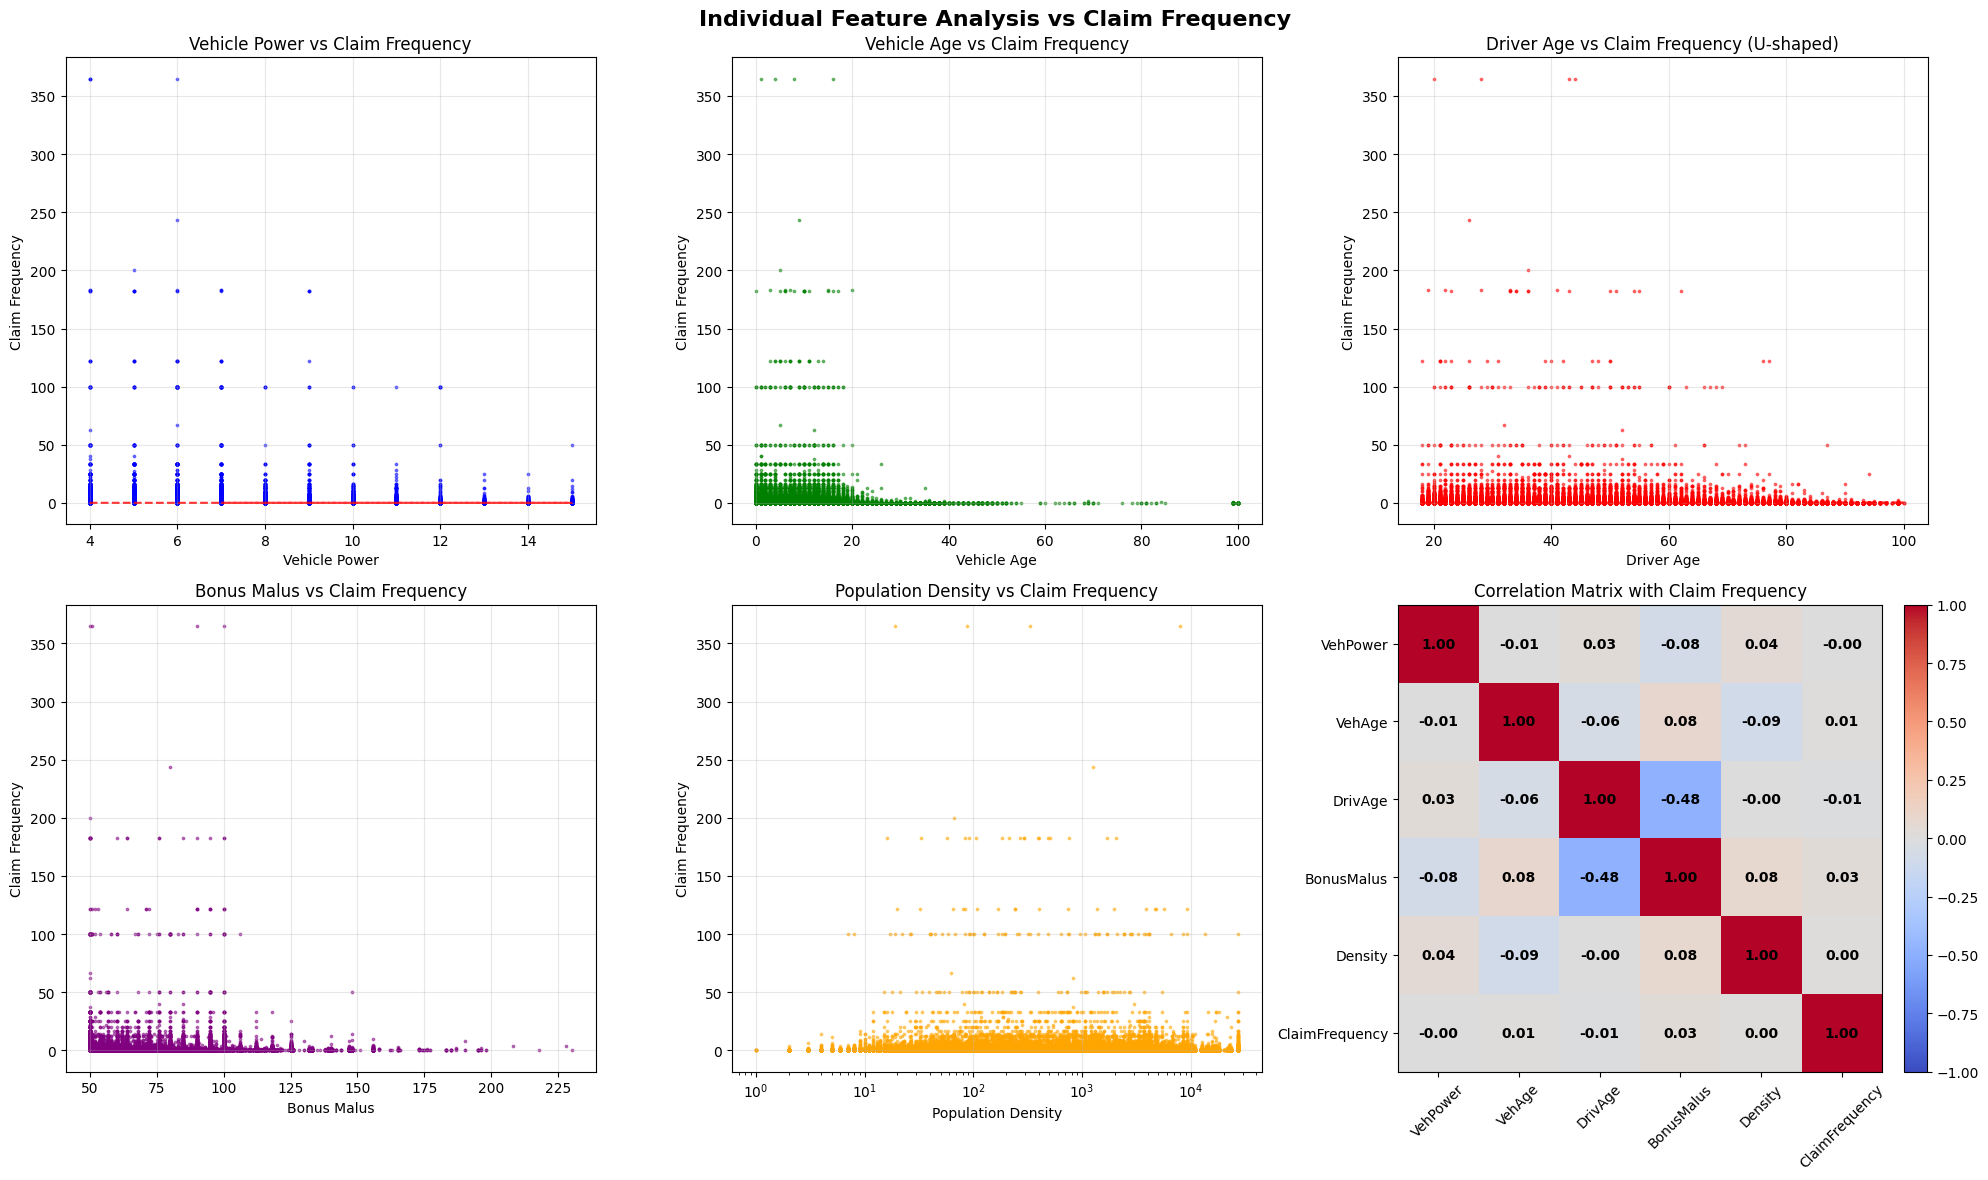


Generating categorical feature analysis vs claim frequency...


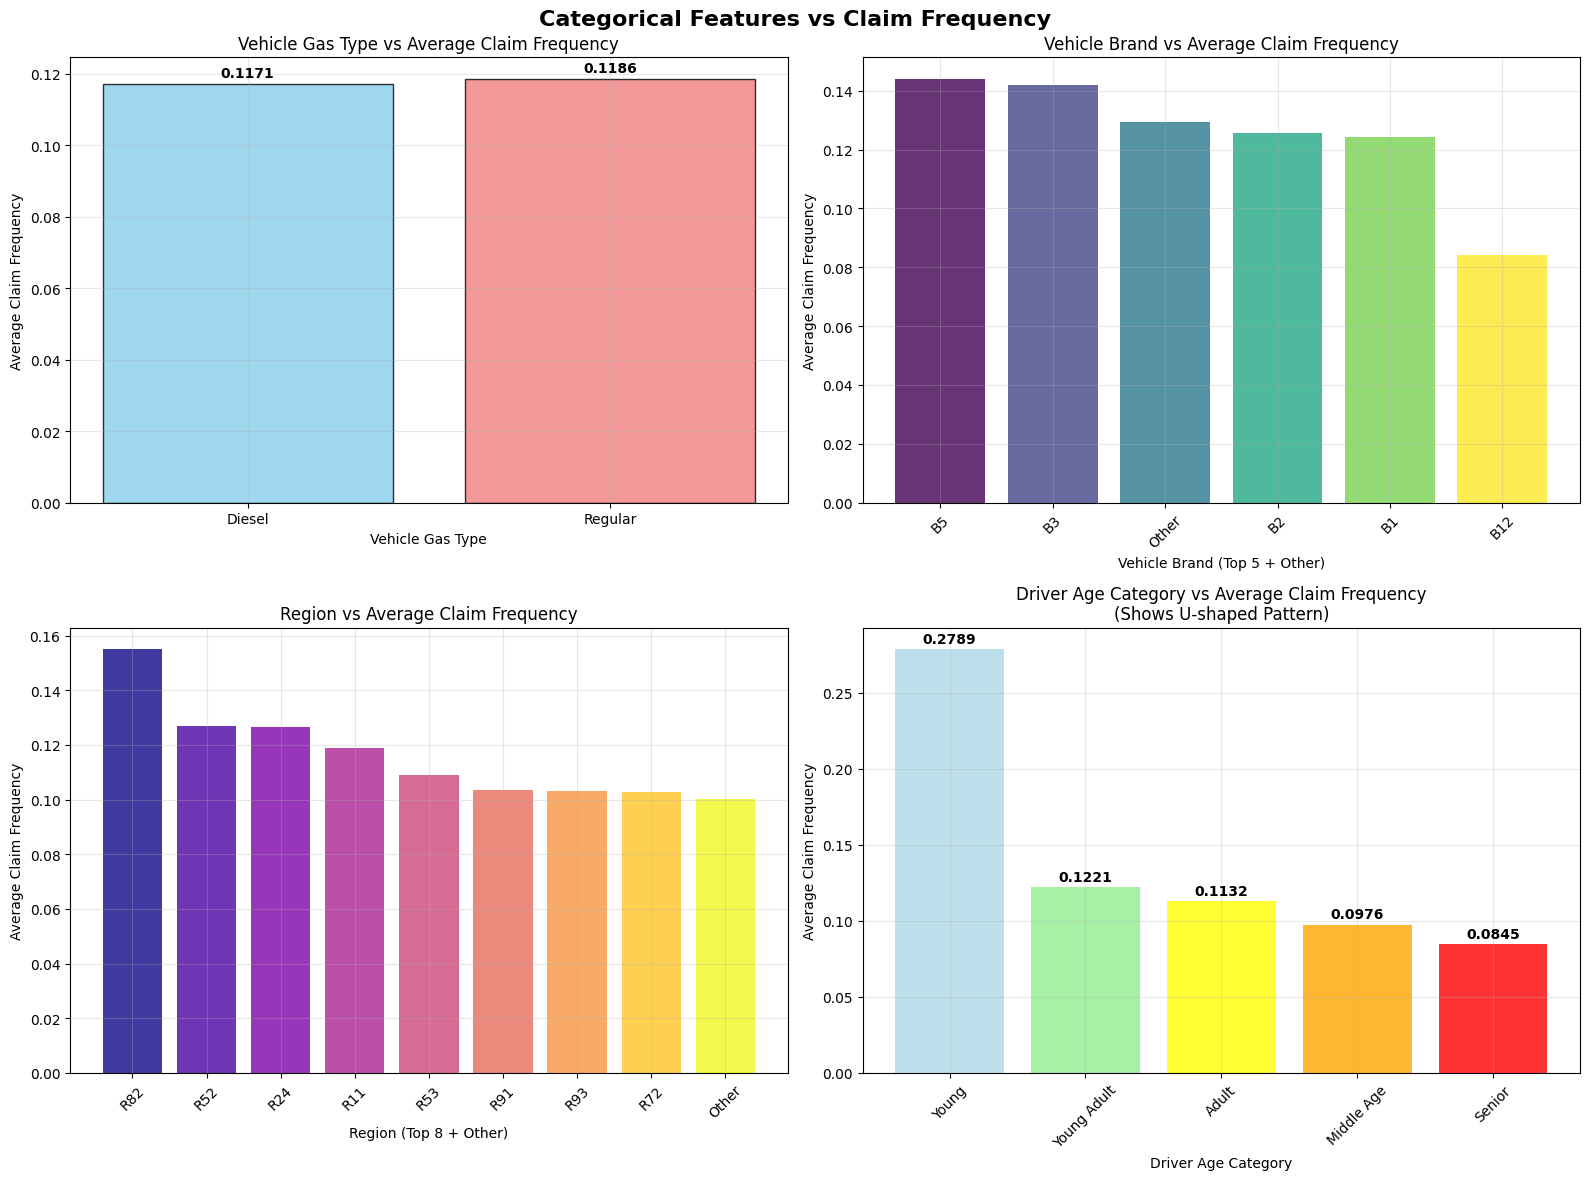


STATISTICAL SUMMARY: CLAIM FREQUENCY RELATIONSHIPS

Correlations with Claim Frequency (strongest first):
--------------------------------------------------
BonusMalus  : 0.0288 (weak positive)
DrivAge     : -0.0139 (weak negative)
VehAge      : 0.0065 (weak positive)
Density     : 0.0032 (weak positive)
VehPower    : -0.0020 (weak negative)

Categorical Feature Analysis:
--------------------------------------------------
VehGas - Diesel vs Regular difference: 0.0015
VehBrand - Highest vs Lowest difference: 0.0599
Region - Highest vs Lowest difference: 0.0549
DrivAge bins - Confirms U-shaped pattern (Young/Senior higher risk)

Overall Claim Frequency Statistics:
--------------------------------------------------
Mean frequency: 0.117907
Median frequency: 0.000000
Standard deviation: 2.002881
% with zero claims: 96.32%
% with high frequency (>0.5): 3.68%

✓ Pairplot analysis completed successfully!
Key insights:
- Driver age shows clear U-shaped relationship with claim frequency
- Bonus

In [6]:
# Create a working copy
df_pairplot = df_clean.copy()

# For computational efficiency, sample the data if it's very large
n_samples = len(df_pairplot)
max_samples_for_pairplot = 5000  # Adjust based on your computational capacity

# Step 2: Select and prepare features for pairplot
# Numerical features (continuous and discrete)
numerical_features = ['VehPower', 'VehAge', 'DrivAge', 'BonusMalus', 'Density']

# Create categorical versions for better visualization
print("\nPreparing categorical features for visualization...")

# VehGas (already categorical)
df_pairplot['VehGas_cat'] = df_pairplot['VehGas']

# VehBrand - keep only top 5 brands, group others as 'Other'
top_brands = df_pairplot['VehBrand'].value_counts().head(5).index
df_pairplot['VehBrand_cat'] = df_pairplot['VehBrand'].apply(
    lambda x: x if x in top_brands else 'Other'
)

# Region - keep only top 8 regions, group others as 'Other'
top_regions = df_pairplot['Region'].value_counts().head(8).index
df_pairplot['Region_cat'] = df_pairplot['Region'].apply(
    lambda x: x if x in top_regions else 'Other'
)

# Create binned versions of continuous variables for categorical analysis
df_pairplot['VehPower_bin'] = pd.cut(df_pairplot['VehPower'],
                                    bins=5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])
df_pairplot['DrivAge_bin'] = pd.cut(df_pairplot['DrivAge'],
                                   bins=[17, 25, 35, 50, 65, 100],
                                   labels=['Young', 'Young Adult', 'Adult', 'Middle Age', 'Senior'])
df_pairplot['BonusMalus_bin'] = pd.cut(df_pairplot['BonusMalus'],
                                      bins=[49, 60, 80, 100, 150, 350],
                                      labels=['Excellent', 'Good', 'Average', 'Poor', 'Very Poor'])

# Also create a binned version of ClaimFrequency for color coding
df_pairplot['ClaimFreq_bin'] = pd.cut(df_pairplot['ClaimFrequency'],
                                     bins=[0, 0.001, 0.1, 0.3, 0.5, float('inf')],
                                     labels=['Zero', 'Very Low', 'Low', 'Medium', 'High'],
                                     include_lowest=True)

print("✓ Categorical features prepared")

# Step 3: Create comprehensive pairplot - Numerical Features
print("\nGenerating pairplot for numerical features...")

# Select features for pairplot (including target)
pairplot_features = numerical_features + ['ClaimFrequency']
df_numerical = df_pairplot[pairplot_features].copy()

# Handle any infinite or very large values
for col in df_numerical.columns:
    df_numerical[col] = df_numerical[col].replace([np.inf, -np.inf], np.nan)
    if df_numerical[col].dtype in ['float64', 'int64']:
        # Cap extreme outliers at 99.5th percentile
        cap_value = df_numerical[col].quantile(0.995)
        df_numerical[col] = df_numerical[col].clip(upper=cap_value)

# Remove any rows with NaN values
df_numerical_clean = df_numerical.dropna()
print(f"✓ Cleaned numerical data shape: {df_numerical_clean.shape}")

# Create the pairplot
plt.figure(figsize=(18, 15))

# Custom pairplot with ClaimFrequency highlighting
g = sns.PairGrid(df_numerical_clean, height=2.5)

# Upper triangle: scatter plots with claim frequency color coding
def scatter_with_freq(x, y, **kwargs):
    # Create frequency bins for coloring
    freq_values = df_numerical_clean.loc[x.index, 'ClaimFrequency']
    scatter = plt.scatter(x, y, c=freq_values, cmap='viridis', alpha=0.6, s=8)
    plt.colorbar(scatter, label='Claim Frequency')

def hist_with_freq(x, **kwargs):
    plt.hist(x, bins=30, alpha=0.7, edgecolor='black')

# Map different plot types
g.map_upper(scatter_with_freq)
g.map_diag(hist_with_freq)
g.map_lower(sns.scatterplot, alpha=0.6, s=8)

# Add titles and labels
g.fig.suptitle('Pairplot: Numerical Features vs Claim Frequency',
               fontsize=16, fontweight='bold', y=1.02)

plt.tight_layout()
plt.show()

# Step 4: Focused pairplot with claim frequency as the main focus
print("\nGenerating focused pairplot with Claim Frequency as target...")

# Select a subset of most important features + target
key_features = ['VehPower', 'VehAge', 'DrivAge', 'BonusMalus', 'ClaimFrequency']
df_focused = df_pairplot[key_features].copy()

# Clean the data
for col in df_focused.columns:
    df_focused[col] = df_focused[col].replace([np.inf, -np.inf], np.nan)
    if col != 'ClaimFrequency':
        cap_value = df_focused[col].quantile(0.995)
        df_focused[col] = df_focused[col].clip(upper=cap_value)

df_focused_clean = df_focused.dropna()

# Add frequency categories for better visualization
df_focused_clean['Freq_Category'] = pd.cut(df_focused_clean['ClaimFrequency'],
                                          bins=[0, 0.001, 0.2, 0.5, float('inf')],
                                          labels=['No Claims', 'Low Freq', 'Medium Freq', 'High Freq'],
                                          include_lowest=True)

# Create focused pairplot
plt.figure(figsize=(15, 12))

# Use the frequency category as hue for better distinction
g2 = sns.pairplot(df_focused_clean,
                  vars=['VehPower', 'VehAge', 'DrivAge', 'BonusMalus'],
                  hue='Freq_Category',
                  palette='viridis',
                  plot_kws={'alpha': 0.6, 's': 10},
                  diag_kind='hist',
                  height=2.8)

g2.fig.suptitle('Focused Pairplot: Key Features Colored by Claim Frequency Category',
                fontsize=14, fontweight='bold', y=1.02)

# Adjust legend
g2._legend.set_title('Claim Frequency')
g2._legend.set_bbox_to_anchor((1.05, 0.5))

plt.tight_layout()
plt.show()

# Step 5: Feature vs Claim Frequency - Individual Analysis
print("\nGenerating individual feature vs claim frequency plots...")

fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Individual Feature Analysis vs Claim Frequency', fontsize=16, fontweight='bold')

# Plot 1: VehPower vs ClaimFrequency
axes[0, 0].scatter(df_pairplot['VehPower'], df_pairplot['ClaimFrequency'],
                  alpha=0.5, s=3, c='blue')
axes[0, 0].set_xlabel('Vehicle Power')
axes[0, 0].set_ylabel('Claim Frequency')
axes[0, 0].set_title('Vehicle Power vs Claim Frequency')
axes[0, 0].grid(True, alpha=0.3)

# Add trend line
z = np.polyfit(df_pairplot['VehPower'], df_pairplot['ClaimFrequency'], 1)
p = np.poly1d(z)
axes[0, 0].plot(df_pairplot['VehPower'], p(df_pairplot['VehPower']), "r--", alpha=0.8)

# Plot 2: VehAge vs ClaimFrequency
axes[0, 1].scatter(df_pairplot['VehAge'], df_pairplot['ClaimFrequency'],
                  alpha=0.5, s=3, c='green')
axes[0, 1].set_xlabel('Vehicle Age')
axes[0, 1].set_ylabel('Claim Frequency')
axes[0, 1].set_title('Vehicle Age vs Claim Frequency')
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: DrivAge vs ClaimFrequency (U-shaped relationship)
axes[0, 2].scatter(df_pairplot['DrivAge'], df_pairplot['ClaimFrequency'],
                  alpha=0.5, s=3, c='red')
axes[0, 2].set_xlabel('Driver Age')
axes[0, 2].set_ylabel('Claim Frequency')
axes[0, 2].set_title('Driver Age vs Claim Frequency (U-shaped)')
axes[0, 2].grid(True, alpha=0.3)

# Add U-shaped trend line (quadratic)
age_sorted = np.sort(df_pairplot['DrivAge'])
z_quad = np.polyfit(df_pairplot['DrivAge'], df_pairplot['ClaimFrequency'], 2)
p_quad = np.poly1d(z_quad)
axes[0, 2].plot(age_sorted, p_quad(age_sorted), "r--", alpha=0.8, linewidth=2)

# Plot 4: BonusMalus vs ClaimFrequency
axes[1, 0].scatter(df_pairplot['BonusMalus'], df_pairplot['ClaimFrequency'],
                  alpha=0.5, s=3, c='purple')
axes[1, 0].set_xlabel('Bonus Malus')
axes[1, 0].set_ylabel('Claim Frequency')
axes[1, 0].set_title('Bonus Malus vs Claim Frequency')
axes[1, 0].grid(True, alpha=0.3)

# Plot 5: Density vs ClaimFrequency
axes[1, 1].scatter(df_pairplot['Density'], df_pairplot['ClaimFrequency'],
                  alpha=0.5, s=3, c='orange')
axes[1, 1].set_xlabel('Population Density')
axes[1, 1].set_ylabel('Claim Frequency')
axes[1, 1].set_title('Population Density vs Claim Frequency')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_xscale('log')  # Log scale for density

# Plot 6: Correlation heatmap
corr_features = ['VehPower', 'VehAge', 'DrivAge', 'BonusMalus', 'Density', 'ClaimFrequency']
correlation_matrix = df_pairplot[corr_features].corr()

im = axes[1, 2].imshow(correlation_matrix, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
axes[1, 2].set_xticks(range(len(corr_features)))
axes[1, 2].set_yticks(range(len(corr_features)))
axes[1, 2].set_xticklabels(corr_features, rotation=45)
axes[1, 2].set_yticklabels(corr_features)
axes[1, 2].set_title('Correlation Matrix with Claim Frequency')

# Add correlation values to heatmap
for i in range(len(corr_features)):
    for j in range(len(corr_features)):
        text = axes[1, 2].text(j, i, f'{correlation_matrix.iloc[i, j]:.2f}',
                             ha="center", va="center", color="black", fontweight='bold')

# Add colorbar
plt.colorbar(im, ax=axes[1, 2], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

# Step 6: Categorical Features Analysis
print("\nGenerating categorical feature analysis vs claim frequency...")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Categorical Features vs Claim Frequency', fontsize=16, fontweight='bold')

# VehGas analysis
gas_freq = df_pairplot.groupby('VehGas')['ClaimFrequency'].agg(['mean', 'count', 'std']).reset_index()
axes[0, 0].bar(gas_freq['VehGas'], gas_freq['mean'],
               color=['skyblue', 'lightcoral'], alpha=0.8, edgecolor='black')
axes[0, 0].set_xlabel('Vehicle Gas Type')
axes[0, 0].set_ylabel('Average Claim Frequency')
axes[0, 0].set_title('Vehicle Gas Type vs Average Claim Frequency')
axes[0, 0].grid(True, alpha=0.3)

# Add value labels on bars
for i, v in enumerate(gas_freq['mean']):
    axes[0, 0].text(i, v + 0.001, f'{v:.4f}', ha='center', va='bottom', fontweight='bold')

# VehBrand analysis (top brands only)
brand_freq = df_pairplot.groupby('VehBrand_cat')['ClaimFrequency'].agg(['mean', 'count']).reset_index()
brand_freq = brand_freq.sort_values('mean', ascending=False)

bars = axes[0, 1].bar(range(len(brand_freq)), brand_freq['mean'],
                     color=plt.cm.viridis(np.linspace(0, 1, len(brand_freq))), alpha=0.8)
axes[0, 1].set_xlabel('Vehicle Brand (Top 5 + Other)')
axes[0, 1].set_ylabel('Average Claim Frequency')
axes[0, 1].set_title('Vehicle Brand vs Average Claim Frequency')
axes[0, 1].set_xticks(range(len(brand_freq)))
axes[0, 1].set_xticklabels(brand_freq['VehBrand_cat'], rotation=45)
axes[0, 1].grid(True, alpha=0.3)

# Region analysis
region_freq = df_pairplot.groupby('Region_cat')['ClaimFrequency'].agg(['mean', 'count']).reset_index()
region_freq = region_freq.sort_values('mean', ascending=False)

axes[1, 0].bar(range(len(region_freq)), region_freq['mean'],
               color=plt.cm.plasma(np.linspace(0, 1, len(region_freq))), alpha=0.8)
axes[1, 0].set_xlabel('Region (Top 8 + Other)')
axes[1, 0].set_ylabel('Average Claim Frequency')
axes[1, 0].set_title('Region vs Average Claim Frequency')
axes[1, 0].set_xticks(range(len(region_freq)))
axes[1, 0].set_xticklabels(region_freq['Region_cat'], rotation=45)
axes[1, 0].grid(True, alpha=0.3)

# Driver Age bins analysis
age_bin_freq = df_pairplot.groupby('DrivAge_bin')['ClaimFrequency'].agg(['mean', 'count']).reset_index()

axes[1, 1].bar(range(len(age_bin_freq)), age_bin_freq['mean'],
               color=['lightblue', 'lightgreen', 'yellow', 'orange', 'red'], alpha=0.8)
axes[1, 1].set_xlabel('Driver Age Category')
axes[1, 1].set_ylabel('Average Claim Frequency')
axes[1, 1].set_title('Driver Age Category vs Average Claim Frequency\n(Shows U-shaped Pattern)')
axes[1, 1].set_xticks(range(len(age_bin_freq)))
axes[1, 1].set_xticklabels(age_bin_freq['DrivAge_bin'], rotation=45)
axes[1, 1].grid(True, alpha=0.3)

# Add value labels
for i, v in enumerate(age_bin_freq['mean']):
    axes[1, 1].text(i, v + 0.002, f'{v:.4f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Step 7: Statistical Summary
print("\n" + "=" * 60)
print("STATISTICAL SUMMARY: CLAIM FREQUENCY RELATIONSHIPS")
print("=" * 60)

# Correlation analysis
correlation_with_freq = correlation_matrix['ClaimFrequency'].drop('ClaimFrequency').sort_values(key=abs, ascending=False)

print("\nCorrelations with Claim Frequency (strongest first):")
print("-" * 50)
for feature, corr in correlation_with_freq.items():
    direction = "positive" if corr > 0 else "negative"
    strength = "strong" if abs(corr) > 0.1 else "moderate" if abs(corr) > 0.05 else "weak"
    print(f"{feature:12s}: {corr:6.4f} ({strength} {direction})")

# Categorical analysis summary
print(f"\nCategorical Feature Analysis:")
print("-" * 50)
print(f"VehGas - Diesel vs Regular difference: {gas_freq['mean'].max() - gas_freq['mean'].min():.4f}")
print(f"VehBrand - Highest vs Lowest difference: {brand_freq['mean'].max() - brand_freq['mean'].min():.4f}")
print(f"Region - Highest vs Lowest difference: {region_freq['mean'].max() - region_freq['mean'].min():.4f}")
print(f"DrivAge bins - Confirms U-shaped pattern (Young/Senior higher risk)")

# Overall statistics
print(f"\nOverall Claim Frequency Statistics:")
print("-" * 50)
print(f"Mean frequency: {df_pairplot['ClaimFrequency'].mean():.6f}")
print(f"Median frequency: {df_pairplot['ClaimFrequency'].median():.6f}")
print(f"Standard deviation: {df_pairplot['ClaimFrequency'].std():.6f}")
print(f"% with zero claims: {(df_pairplot['ClaimFrequency'] == 0).mean() * 100:.2f}%")
print(f"% with high frequency (>0.5): {(df_pairplot['ClaimFrequency'] > 0.5).mean() * 100:.2f}%")

print("\n✓ Pairplot analysis completed successfully!")
print("Key insights:")
print("- Driver age shows clear U-shaped relationship with claim frequency")
print("- Bonus-Malus has positive correlation (higher penalty = higher frequency)")
print("- Vehicle characteristics show modest relationships")
print("- Regional and brand differences exist but are relatively small")
print("- Most policies have very low claim frequencies (highly skewed distribution)")

## Exercise 2: Poisson GLM

In this section of the code, we create a baseline model which allows us to then later compare the neural network approach to. The model we use is a Poisson Generalized Linear Model (GLM), which is commonly used for insurance frequency claim prediction.

#### Define functions for evaluation metrics

In [50]:
def weighted_mae(y_true, y_pred, weights):
    return np.sum(weights * np.abs(y_true - y_pred)) / np.sum(weights)

def weighted_mse(y_true, y_pred, weights):
    return np.sum(weights * (y_true - y_pred)**2) / np.sum(weights)

def weighted_poisson_deviance(y_true, y_pred, weights):
    eps = 1e-9  # avoid log(0)
    y_pred = np.clip(y_pred, eps, None)
    y_true = np.clip(y_true, eps, None)
    loss = 2 * (y_pred - y_true + y_true * (np.log(y_true) - np.log(y_pred)))
    return np.sum(weights * loss) / np.sum(weights)


### Exercise 2a: Feature Engineering

Feature	Transformation
VehPower --> log(): Reduces skew, models diminishing marginal impact of power

VehAge --> Binned categorical:	Captures nonlinear effects (e.g. aging effects change over time)

DrivAge -->	log():	Makes age effects smoother and more interpretable

BonusMalus --> log():	Often very skewed, log helps normalize and stabilize impact

Density	--> log():	Extreme variation in population density — log compresses scale

In [42]:
# Initiate dataset for feature engineering
df_processed = df_raw.copy()

# Log transforms
df_processed['log_VehPower'] = np.log(df_processed['VehPower'].replace(0, np.nan))
df_processed['log_DrivAge'] = np.log(df_processed['DrivAge'].replace(0, np.nan))
df_processed['log_BonusMalus'] = np.log(df_processed['BonusMalus'].replace(0, np.nan))
df_processed['log_Density'] = np.log(df_processed['Density'].replace(0, np.nan))

# VehAge binning
df_processed['VehAge_binned'] = pd.cut(
    df_processed['VehAge'],
    bins=[0, 6, 13, np.inf],
    labels=['[0,6)', '[6,13)', '[13,∞)'],
    right=False
)

# Add engineered features: Polynomial and interaction terms (based on raw values)
df_processed['DrivAge_squared'] = df_processed['DrivAge'] ** 2
df_processed['Interaction_BM_DA'] = df_processed['BonusMalus'] * df_processed['DrivAge']
df_processed['Interaction_BM_DA2'] = df_processed['BonusMalus'] * df_processed['DrivAge_squared']



# One-hot encode categorical features
df_processed = pd.get_dummies(df_processed, columns=['VehBrand', 'VehGas', 'Region', 'VehAge_binned'], drop_first=False)

# Final list of features available for modelling
print(df_processed.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 678007 entries, 0 to 678006
Data columns (total 52 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   VehPower              678007 non-null  int64  
 1   VehAge                678007 non-null  int64  
 2   DrivAge               678007 non-null  int64  
 3   BonusMalus            678007 non-null  int64  
 4   Density               678007 non-null  int64  
 5   Exposure              678007 non-null  float64
 6   ClaimNb               678007 non-null  int64  
 7   log_VehPower          678007 non-null  float64
 8   log_DrivAge           678007 non-null  float64
 9   log_BonusMalus        678007 non-null  float64
 10  log_Density           678007 non-null  float64
 11  DrivAge_squared       678007 non-null  int64  
 12  Interaction_BM_DA     678007 non-null  int64  
 13  Interaction_BM_DA2    678007 non-null  int64  
 14  VehBrand_B1           678007 non-null  bool   
 15  

In [51]:
# Define base features (excluding the interaction terms for model 1)
base_features = [
    'log_VehPower',
    'log_DrivAge',
    'log_BonusMalus',
    'log_Density'
]

# Interaction features
interaction_features = [
    'DrivAge_squared',
    'Interaction_BM_DA',
    'Interaction_BM_DA2'
]

# 2C adding back the DrivAge
extension = ['DrivAge']

# Get all one-hot encoded columns
vehbrand_cols = [col for col in df_processed.columns if col.startswith('VehBrand_')]
vehgas_cols = [col for col in df_processed.columns if col.startswith('VehGas_')]
region_cols = [col for col in df_processed.columns if col.startswith('Region_')]
vehage_binned_cols = [col for col in df_processed.columns if col.startswith('VehAge_binned_')]

# All categorical features
categorical_features = vehbrand_cols + vehgas_cols + region_cols + vehage_binned_cols

print(f"\nNumber of VehBrand categories: {len(vehbrand_cols)}")
print(f"Number of VehGas categories: {len(vehgas_cols)}")
print(f"Number of Region categories: {len(region_cols)}")
print(f"Number of VehAge_binned categories: {len(vehage_binned_cols)}")

# Model 1: Base features + categorical (excluding interaction terms)
model1_features = base_features + categorical_features

# Model 2: Base features + categorical + interaction terms
model2_features = base_features + categorical_features + interaction_features + extension



Number of VehBrand categories: 11
Number of VehGas categories: 2
Number of Region categories: 22
Number of VehAge_binned categories: 3


In [44]:
# Prepare datasets for model 1 and model 2
df_glm = df_processed.copy()

# X1: Feature matrix for Model 1 (without interaction terms)
X1 = df_glm[model1_features].copy()

# X2: Feature matrix for Model 2 (with interaction terms)
X2 = df_glm[model2_features].copy()

# y: Target variable (number of claims)
y = df_glm['ClaimNb'].copy()

# w: Sample weights (exposure time)
w = df_glm['Exposure'].copy()

### Exercise 2b: Fitting the baseline Poisson GLM

#### Train-Test Split

In [47]:
# Step 1: 90/10 split - separate out test set (10% of data)
X1_temp, X1_test, X2_temp, X2_test, y_temp, y_test, w_temp, w_test = train_test_split(
    X1, X2, y, w,
    test_size=0.1,
    random_state=4
)

# Step 2: Split remaining into train (72%) and validation (18%)
# This gives us 72/18/10 split overall
X1_train, X1_val, X2_train, X2_val, y_train, y_val, w_train, w_val = train_test_split(
    X1_temp, X2_temp, y_temp, w_temp,
    test_size=0.2,  # 0.2 of 0.9 = 0.18 of total
    random_state=4)

# Step 3: Scale numeric features (only!)
features_to_scale1 = [
    'log_VehPower',
    'log_DrivAge',
    'log_BonusMalus',
    'log_Density',
]
features_to_scale2 = [
    'log_VehPower',
    'log_DrivAge',
    'log_BonusMalus',
    'log_Density',
    'DrivAge',
    'Interaction_BM_DA',
    'Interaction_BM_DA2',
    'DrivAge_squared'
]

# Model 1 scaling
X1_train_scaled = X1_train.copy()
X1_val_scaled = X1_val.copy()
X1_test_scaled = X1_test.copy()

scaler = StandardScaler()
X1_train_scaled[features_to_scale1] = scaler.fit_transform(X1_train[features_to_scale1])
X1_val_scaled[features_to_scale1] = scaler.transform(X1_val[features_to_scale1])
X1_test_scaled[features_to_scale1] = scaler.transform(X1_test[features_to_scale1])

# Model 2 scaling
X2_train_scaled = X2_train.copy()
X2_val_scaled = X2_val.copy()
X2_test_scaled = X2_test.copy()

scaler2 = StandardScaler()
X2_train_scaled[features_to_scale2] = scaler2.fit_transform(X2_train[features_to_scale2])
X2_val_scaled[features_to_scale2] = scaler2.transform(X2_val[features_to_scale2])
X2_test_scaled[features_to_scale2] = scaler2.transform(X2_test[features_to_scale2])


#### Fitting the Poisson GLM

In [52]:
# Fit the Poisson GLM
poisson_glm1 = PoissonRegressor(alpha=0, max_iter=1000)
poisson_glm1.fit(X1_train_scaled, y_train, sample_weight=w_train)

# --- Predict on each set ---
λ_train1 = poisson_glm1.predict(X1_train_scaled)
λ_val1 = poisson_glm1.predict(X1_val_scaled)
λ_test1 = poisson_glm1.predict(X1_test_scaled)

# --- Save predictions and targets for later comparison ---
λ_test_original = λ_test1.copy()
y_test_extended = y_test.copy()
w_test_original = w_test.copy()

λ_val_original = λ_val1.copy()
y_val_original = y_val.copy()
w_val_original = w_val.copy()

λ_train_original = λ_train1.copy()
y_train_original = y_train.copy()
w_train_original = w_train.copy()

# --- Save metrics for original model ---
mae_train_original = weighted_mae(y_train, λ_train1, w_train)
mse_train_original = weighted_mse(y_train, λ_train1, w_train)
loss_train_original = weighted_poisson_deviance(y_train, λ_train1, w_train)

mae_val_original = weighted_mae(y_val, λ_val1, w_val)
mse_val_original = weighted_mse(y_val, λ_val1, w_val)
loss_val_original = weighted_poisson_deviance(y_val, λ_val1, w_val)

mae_test_original = weighted_mae(y_test, λ_test1, w_test)
mse_test_original = weighted_mse(y_test, λ_test1, w_test)
loss_test_original = weighted_poisson_deviance(y_test, λ_test1, w_test)

#### Model Evaluation for Model 1

Poisson GLM Results (Exercise 2b):
Train:      MAE = 0.0955 | MSE = 0.0534 | Loss = 0.2025
Validation: MAE = 0.0953 | MSE = 0.0534 | Loss = 0.2019
Test:       MAE = 0.0959 | MSE = 0.0536 | Loss = 0.2048


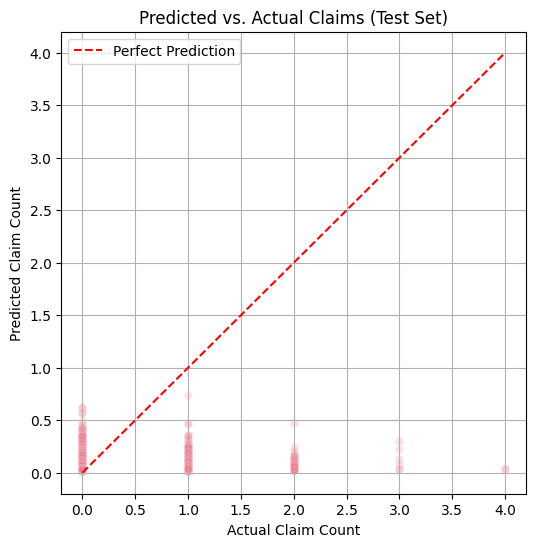

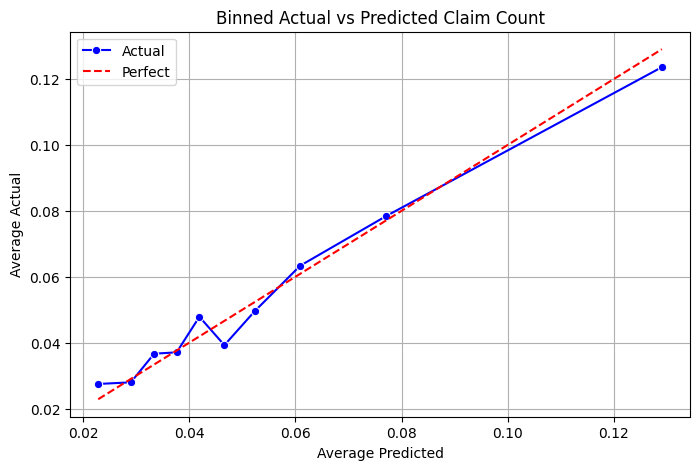

In [55]:
# Print MAE, MSE and loss on train and test data sets
print("Poisson GLM Results (Exercise 2b):")
print(f"Train:      MAE = {mae_train_original:.4f} | MSE = {mse_train_original:.4f} | Loss = {loss_train_original:.4f}")
print(f"Validation: MAE = {mae_val_original:.4f} | MSE = {mse_val_original:.4f} | Loss = {loss_val_original:.4f}")
print(f"Test:       MAE = {mae_test_original:.4f} | MSE = {mse_test_original:.4f} | Loss = {loss_test_original:.4f}")

# Plot Predicted vs Actual Claims (with density/alpha)
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test, y=λ_test1, alpha=0.2)
plt.plot([0, max(y_test)], [0, max(y_test)], color='red', linestyle='--', label='Perfect Prediction')
plt.xlabel('Actual Claim Count')
plt.ylabel('Predicted Claim Count')
plt.title('Predicted vs. Actual Claims (Test Set)')
plt.legend()
plt.grid(True)
plt.show()

# Average Predicted vs Actual Claim Counts
# Combine into a DataFrame
df_pred = pd.DataFrame({
    'y_true': y_test,
    'y_pred': λ_test1,
    'weight': w_test
})

# Bin predictions
df_pred['pred_bin'] = pd.qcut(df_pred['y_pred'], q=10, duplicates='drop')  # 10 quantile bins

# Compute weighted average actual and predicted values per bin
bin_summary = df_pred.groupby('pred_bin', group_keys=False).apply(
    lambda g: pd.Series({
        'avg_actual': np.average(g['y_true'], weights=g['weight']),
        'avg_pred': np.average(g['y_pred'], weights=g['weight']),
        'count': len(g)
    }),
    include_groups=False
).reset_index()


# Plot
plt.figure(figsize=(8, 5))
sns.lineplot(data=bin_summary, x='avg_pred', y='avg_actual', marker='o',color = 'blue', label='Actual')
sns.lineplot(data=bin_summary, x='avg_pred', y='avg_pred', color='red', linestyle='--', label='Perfect')
plt.title('Binned Actual vs Predicted Claim Count')
plt.xlabel('Average Predicted')
plt.ylabel('Average Actual')
plt.legend()
plt.grid(True)
plt.show()

### Exercise 2c: Fitting the extended Poisson GLM

#### Fit the model with extended set of features

In [56]:
# Fit the Poisson GLM
poisson_glm2 = PoissonRegressor(alpha=0, max_iter=1000)
poisson_glm2.fit(X2_train_scaled, y_train, sample_weight=w_train)

# --- Predict on each set ---
λ_train2 = poisson_glm2.predict(X2_train_scaled)
λ_val2 = poisson_glm2.predict(X2_val_scaled)
λ_test2 = poisson_glm2.predict(X2_test_scaled)

# --- Save metrics for later comparison ---
mae_test_extended = weighted_mae(y_test, λ_test2, w_test)
mse_test_extended = weighted_mse(y_test, λ_test2, w_test)
loss_test_extended = weighted_poisson_deviance(y_test, λ_test2, w_test)

mae_val_extended = weighted_mae(y_val, λ_val2, w_val)
mse_val_extended = weighted_mse(y_val, λ_val2, w_val)
loss_val_extended = weighted_poisson_deviance(y_val, λ_val2, w_val)

mae_train_extended = weighted_mae(y_train, λ_train2, w_train)
mse_train_extended = weighted_mse(y_train, λ_train2, w_train)
loss_train_extended = weighted_poisson_deviance(y_train, λ_train2, w_train)

#### Evaluation for Model 2

Poisson GLM Results (Exercise 2c):
Train:      MAE = 0.0954 | MSE = 0.0534 | Loss = 0.2023
Validation: MAE = 0.0952 | MSE = 0.0534 | Loss = 0.2015
Test:       MAE = 0.0958 | MSE = 0.0537 | Loss = 0.2051


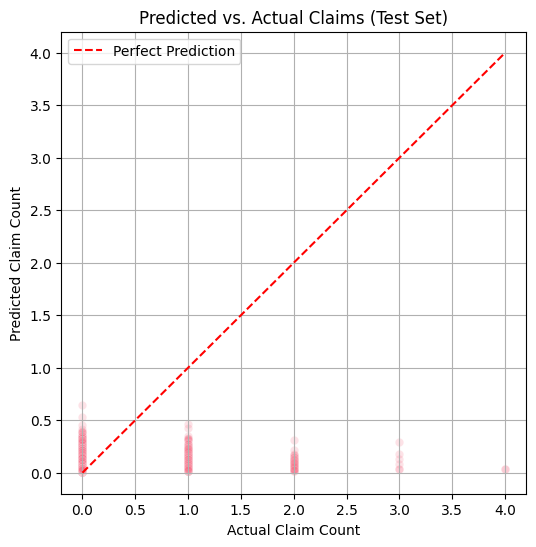

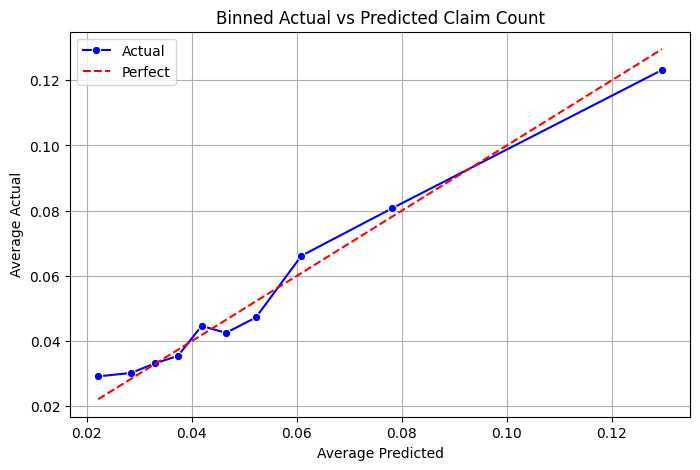

In [58]:
# Print MAE, MSE and loss on train and test data sets
print("Poisson GLM Results (Exercise 2c):")
print(f"Train:      MAE = {mae_train_extended:.4f} | MSE = {mse_train_extended:.4f} | Loss = {loss_train_extended:.4f}")
print(f"Validation: MAE = {mae_val_extended:.4f} | MSE = {mse_val_extended:.4f} | Loss = {loss_val_extended:.4f}")
print(f"Test:       MAE = {mae_test_extended:.4f} | MSE = {mse_test_extended:.4f} | Loss = {loss_test_extended:.4f}")

# Plot Predicted vs Actual Claims (with density/alpha)
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test, y=λ_test2, alpha=0.2)
plt.plot([0, max(y_test)], [0, max(y_test)], color='red', linestyle='--', label='Perfect Prediction')
plt.xlabel('Actual Claim Count')
plt.ylabel('Predicted Claim Count')
plt.title('Predicted vs. Actual Claims (Test Set)')
plt.legend()
plt.grid(True)
plt.show()

# Average Predicted vs Actual Claim Counts
# Combine into a DataFrame
df_pred = pd.DataFrame({
    'y_true': y_test,
    'y_pred': λ_test2,
    'weight': w_test
})

# Bin predictions
df_pred['pred_bin'] = pd.qcut(df_pred['y_pred'], q=10, duplicates='drop')  # 10 quantile bins

# Compute weighted average actual and predicted values per bin
bin_summary = df_pred.groupby('pred_bin', group_keys=False).apply(
    lambda g: pd.Series({
        'avg_actual': np.average(g['y_true'], weights=g['weight']),
        'avg_pred': np.average(g['y_pred'], weights=g['weight']),
        'count': len(g)
    }),
    include_groups=False
).reset_index()

# Plot
plt.figure(figsize=(8, 5))
sns.lineplot(data=bin_summary, x='avg_pred', y='avg_actual', marker='o', color='blue', label='Actual')
sns.lineplot(data=bin_summary, x='avg_pred', y='avg_pred', color='red', linestyle='--', label='Perfect')
plt.title('Binned Actual vs Predicted Claim Count')
plt.xlabel('Average Predicted')
plt.ylabel('Average Actual')
plt.legend()
plt.grid(True)
plt.show()


### Exercise 2: Comparison between the two models

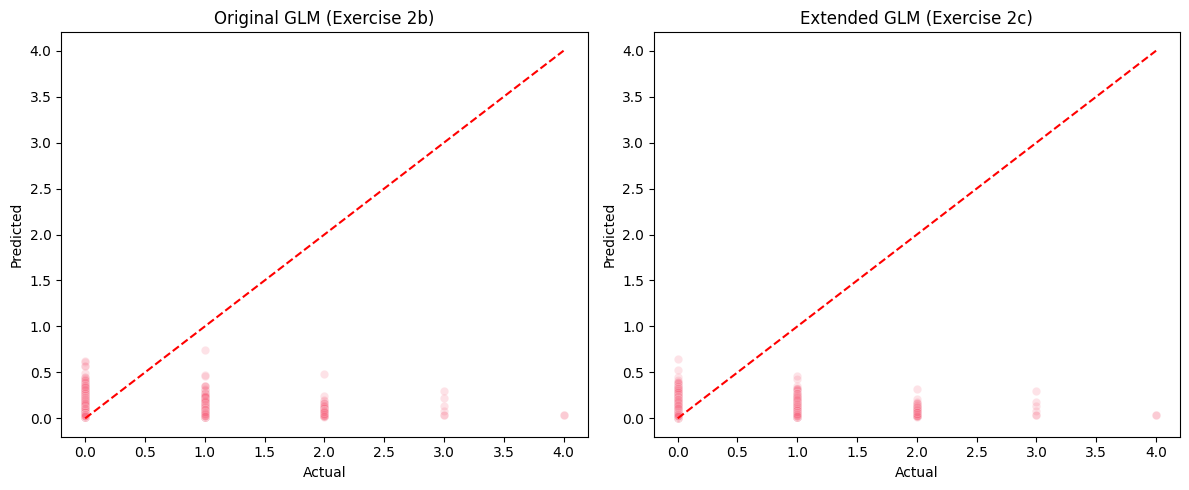

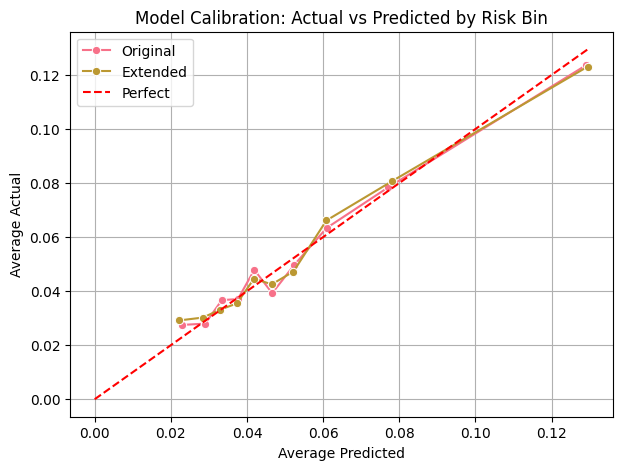

Comparison of Poisson GLM Models on Test Set
          Metric  Model 2(b) – Original  Model 2(c) – Extended  Relative Improvement
             MAE                 0.0959                 0.0958                0.1028
             MSE                 0.0536                 0.0537               -0.0487
Poisson Deviance                 0.2048                 0.2051               -0.1134


In [63]:
# New GLM predictions (from Exercise 2c)
λ_test_extended = λ_test2       # Corrected reference to extended model predictions

# Actual values (same for both models)
y_true_test = y_test

plt.figure(figsize=(12, 5))

# --- Left: Original GLM ---
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_true_test, y=λ_test_original, alpha=0.2)
plt.plot([0, max(y_true_test)], [0, max(y_true_test)], 'r--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Original GLM (Exercise 2b)")

# --- Right: Extended GLM ---
plt.subplot(1, 2, 2)
sns.scatterplot(x=y_true_test, y=λ_test_extended, alpha=0.2)
plt.plot([0, max(y_true_test)], [0, max(y_true_test)], 'r--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Extended GLM (Exercise 2c)")

plt.tight_layout()
plt.show()

# Comparison: Binned Average Actual vs Predicted
def make_binned_comparison(y_true, y_pred, weights, label):
    df = pd.DataFrame({
        'y_true': y_true,
        'y_pred': y_pred,
        'weight': weights
    })
    df['bin'] = pd.qcut(df['y_pred'], q=10, duplicates='drop')
    grouped = df.groupby('bin', group_keys=False).apply(
        lambda g: pd.Series({
            'avg_actual': np.average(g['y_true'], weights=g['weight']),
            'avg_pred': np.average(g['y_pred'], weights=g['weight'])
        }),
        include_groups=False
    )
    grouped['model'] = label
    return grouped.reset_index()


# Create summaries
binned_original = make_binned_comparison(y_test, λ_test_original, w_test, label='Original')
binned_extended = make_binned_comparison(y_test, λ_test_extended, w_test, label='Extended')

# Combine and plot
binned_all = pd.concat([binned_original, binned_extended])

plt.figure(figsize=(7, 5))
sns.lineplot(data=binned_all, x='avg_pred', y='avg_actual', hue='model', marker='o')
plt.plot([0, binned_all['avg_pred'].max()], [0, binned_all['avg_pred'].max()], 'r--', label='Perfect')
plt.xlabel("Average Predicted")
plt.ylabel("Average Actual")
plt.title("Model Calibration: Actual vs Predicted by Risk Bin")
plt.grid(True)
plt.legend()
plt.show()

# Comparison of model in 2 (b) and 2 (c)
comparison_df = pd.DataFrame({
    "Metric": ["MAE", "MSE", "Poisson Deviance"],
    "Model 2(b) – Original": [
        mae_test_original,
        mse_test_original,
        loss_test_original
    ],
    "Model 2(c) – Extended": [
        mae_test_extended,
        mse_test_extended,
        loss_test_extended
    ]
})

# Compute relative improvement (%)
comparison_df["Relative Improvement"] = (
    (comparison_df["Model 2(b) – Original"] - comparison_df["Model 2(c) – Extended"])
    / comparison_df["Model 2(b) – Original"]
) * 100

# Format output
print("Comparison of Poisson GLM Models on Test Set")
print(comparison_df.round(4).to_string(index=False))


## Exercise 3: Poisson Feedforward Neural Network Model

Still working under the Poisson assumption, we can achieve a higher performance by modelling
the mean parameter in (1) with a feedforward neural network, which can be used to perform
feature engineering in an automatic way.

### Baseline Neural Network (20, 20)

In [138]:
# Set random seed so we get the same outcome everytime we run the cell
np.random.seed(4)
tf.random.set_seed(4)
tf.keras.utils.set_random_seed(4)
random.seed(4)

# Build the model
model = Sequential([
    Input(shape=(X1_train_scaled.shape[1],)),
    Dense(20, activation='relu'),
    Dense(20, activation='relu'),
    Dense(1, activation='exponential')
])

In [139]:
# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.01),
    loss=Poisson()
)

In [140]:
# Set random seed so we get the same outcome everytime we run the cell
np.random.seed(4)
tf.random.set_seed(4)
tf.keras.utils.set_random_seed(4)
random.seed(4)

# Train the model
history = model.fit(
    X1_train_scaled, y_train,
    sample_weight=w_train,
    validation_data=(X1_val_scaled, y_val, w_val),
    epochs=100,
    batch_size=10000,
    verbose=1
)

Epoch 1/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1617 - val_loss: 0.1047
Epoch 2/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1049 - val_loss: 0.1039
Epoch 3/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1043 - val_loss: 0.1037
Epoch 4/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1041 - val_loss: 0.1036
Epoch 5/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1039 - val_loss: 0.1035
Epoch 6/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1038 - val_loss: 0.1034
Epoch 7/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1037 - val_loss: 0.1033
Epoch 8/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1035 - val_loss: 0.1031
Epoch 9/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1033 - val_loss: 0.1030
Epoch 10/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1031 - val_loss: 0.1029
Epoch 11/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1030 - val_loss: 0.1028
Epoch 12/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1

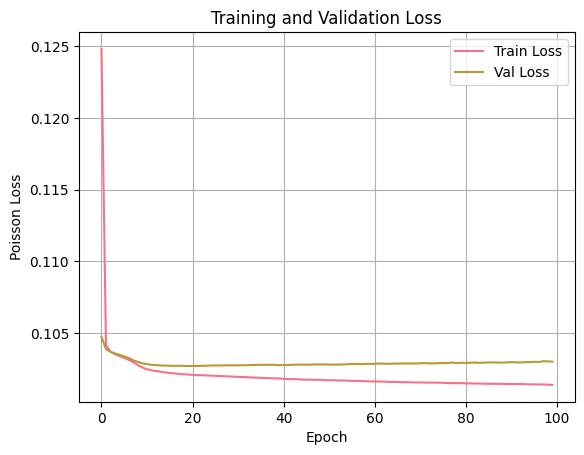

In [141]:
# Plot training history
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Poisson Loss")
plt.legend()
plt.grid(True)
plt.title("Training and Validation Loss")
plt.show()

In [111]:
# Predict and calculate evaluation metrics
λ_train_nn = model.predict(X1_train_scaled).flatten()
λ_val_nn = model.predict(X1_val_scaled).flatten()
λ_test_nn = model.predict(X1_test_scaled).flatten()

# Compute metrics
mae_train_nn = mean_absolute_error(y_train, λ_train_nn, sample_weight=w_train)
mse_train_nn = mean_squared_error(y_train, λ_train_nn, sample_weight=w_train)
loss_train_nn = weighted_poisson_deviance(y_train, λ_train_nn, w_train)

mae_val_nn = mean_absolute_error(y_val, λ_val_nn, sample_weight=w_val)
mse_val_nn = mean_squared_error(y_val, λ_val_nn, sample_weight=w_val)
loss_val_nn = weighted_poisson_deviance(y_val, λ_val_nn, w_val)

mae_test_nn = mean_absolute_error(y_test, λ_test_nn, sample_weight=w_test)
mse_test_nn = mean_squared_error(y_test, λ_test_nn, sample_weight=w_test)
loss_test_nn = weighted_poisson_deviance(y_test, λ_test_nn, w_test)


15256/15256 ━━━━━━━━━━━━━━━━━━━━ 6s 396us/step
3814/3814 ━━━━━━━━━━━━━━━━━━━━ 1s 356us/step
2119/2119 ━━━━━━━━━━━━━━━━━━━━ 1s 349us/step


Poisson Neural Network Performance:
Train:      MAE = 0.0968, MSE = 0.0525, Loss = 0.1869
Validation: MAE = 0.0975, MSE = 0.0537, Loss = 0.1968
Test:       MAE = 0.0978, MSE = 0.0536, Loss = 0.1992


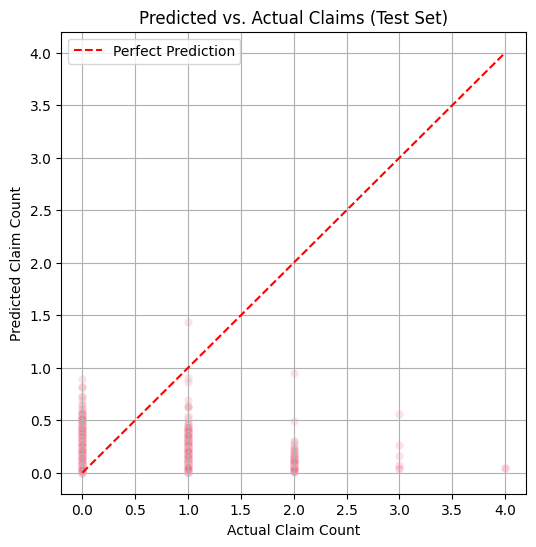

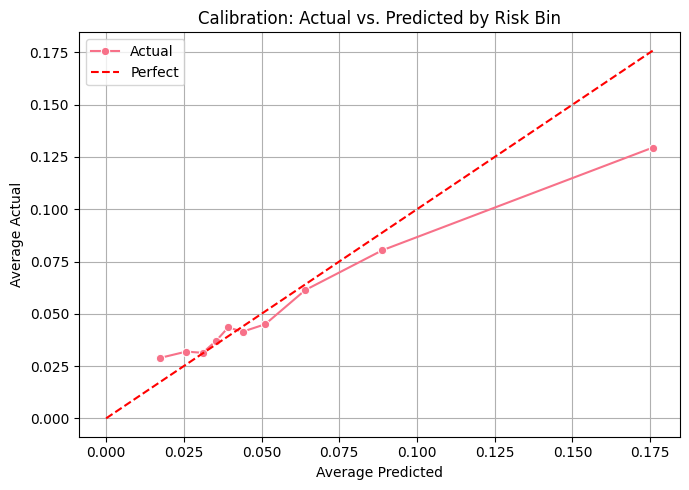

In [112]:
# Model evaluation
# --- Print evaluation metrics ---
print("Poisson Neural Network Performance:")
print(f"Train:      MAE = {mae_train_nn:.4f}, MSE = {mse_train_nn:.4f}, Loss = {loss_train_nn:.4f}")
print(f"Validation: MAE = {mae_val_nn:.4f}, MSE = {mse_val_nn:.4f}, Loss = {loss_val_nn:.4f}")
print(f"Test:       MAE = {mae_test_nn:.4f}, MSE = {mse_test_nn:.4f}, Loss = {loss_test_nn:.4f}")

# --- Plot 1: Predicted vs. Actual Scatter ---
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test, y=λ_test_nn, alpha=0.2)
plt.plot([0, max(y_test)], [0, max(y_test)], 'r--', label='Perfect Prediction')
plt.xlabel("Actual Claim Count")
plt.ylabel("Predicted Claim Count")
plt.title("Predicted vs. Actual Claims (Test Set)")
plt.legend()
plt.grid(True)
plt.show()

# --- Plot 2: Binned Calibration Plot ---
df_pred = pd.DataFrame({
    'y_true': y_test,
    'y_pred': λ_test_nn,
    'weight': w_test
})
df_pred['bin'] = pd.qcut(df_pred['y_pred'], q=10, duplicates='drop')

# Compute weighted average per bin
bin_summary = df_pred.groupby('bin', group_keys=False).apply(
    lambda g: pd.Series({
        'avg_actual': np.average(g['y_true'], weights=g['weight']),
        'avg_pred': np.average(g['y_pred'], weights=g['weight'])
    }),
    include_groups=False
).reset_index()

# Plot
plt.figure(figsize=(7, 5))
sns.lineplot(data=bin_summary, x='avg_pred', y='avg_actual', marker='o', label='Actual')
plt.plot([0, bin_summary['avg_pred'].max()], [0, bin_summary['avg_pred'].max()], 'r--', label='Perfect')
plt.xlabel("Average Predicted")
plt.ylabel("Average Actual")
plt.title("Calibration: Actual vs. Predicted by Risk Bin")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


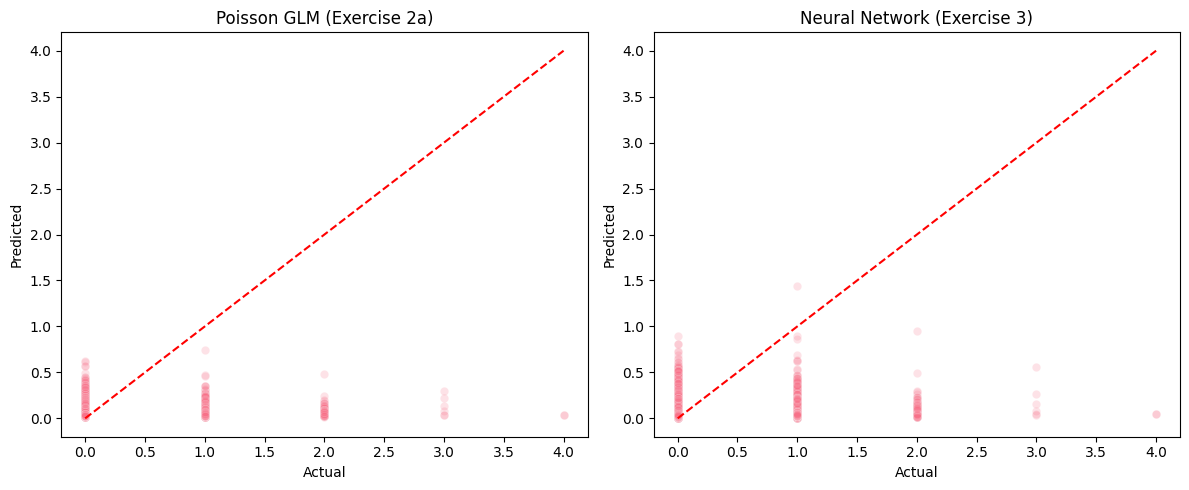

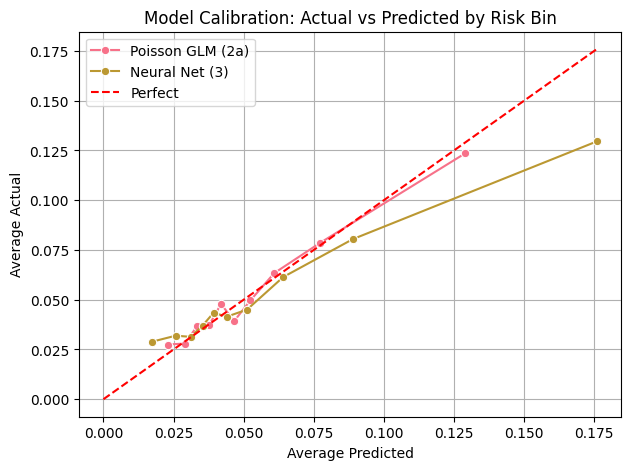

Comparison of Poisson GLM (2a) vs Neural Network (3) on Test Set
          Metric  Poisson GLM (2a)  Neural Net (3)  Relative Improvement (%)
             MAE            0.0959          0.0978                   -1.9399
             MSE            0.0536          0.0536                   -0.0367
Poisson Deviance            0.2048          0.1992                    2.7587


In [113]:
# Set predictions
λ_test_glm = λ_test_original     # Predictions from Poisson GLM (Exercise 2a)
λ_test_nn = λ_test_nn            # Predictions from Neural Network (Exercise 3)
y_true_test = y_test             # True labels

# --- Side-by-side scatter plots ---
plt.figure(figsize=(12, 5))

# Left: Poisson GLM (2a)
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_true_test, y=λ_test_glm, alpha=0.2)
plt.plot([0, max(y_true_test)], [0, max(y_true_test)], 'r--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Poisson GLM (Exercise 2a)")

# Right: Neural Network (3)
plt.subplot(1, 2, 2)
sns.scatterplot(x=y_true_test, y=λ_test_nn, alpha=0.2)
plt.plot([0, max(y_true_test)], [0, max(y_true_test)], 'r--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Neural Network (Exercise 3)")

plt.tight_layout()
plt.show()

# --- Calibration Plot ---
def make_binned_comparison(y_true, y_pred, weights, label):
    df = pd.DataFrame({
        'y_true': y_true,
        'y_pred': y_pred,
        'weight': weights
    })
    df['bin'] = pd.qcut(df['y_pred'], q=10, duplicates='drop')
    grouped = df.groupby('bin', group_keys=False).apply(
        lambda g: pd.Series({
            'avg_actual': np.average(g['y_true'], weights=g['weight']),
            'avg_pred': np.average(g['y_pred'], weights=g['weight'])
        }),
        include_groups=False
    )
    grouped['model'] = label
    return grouped.reset_index()

# Create summaries
binned_glm = make_binned_comparison(y_test, λ_test_glm, w_test, label='Poisson GLM (2a)')
binned_nn = make_binned_comparison(y_test, λ_test_nn, w_test, label='Neural Net (3)')

# Combine and plot
binned_all = pd.concat([binned_glm, binned_nn])

plt.figure(figsize=(7, 5))
sns.lineplot(data=binned_all, x='avg_pred', y='avg_actual', hue='model', marker='o')
plt.plot([0, binned_all['avg_pred'].max()], [0, binned_all['avg_pred'].max()], 'r--', label='Perfect')
plt.xlabel("Average Predicted")
plt.ylabel("Average Actual")
plt.title("Model Calibration: Actual vs Predicted by Risk Bin")
plt.grid(True)
plt.legend()
plt.show()

# --- Final Metric Comparison Table ---
comparison_df = pd.DataFrame({
    "Metric": ["MAE", "MSE", "Poisson Deviance"],
    "Poisson GLM (2a)": [
        mae_test_original,
        mse_test_original,
        loss_test_original
    ],
    "Neural Net (3)": [
        mae_test_nn,
        mse_test_nn,
        loss_test_nn
    ]
})

# Compute relative improvement (%)
comparison_df["Relative Improvement (%)"] = (
    (comparison_df["Poisson GLM (2a)"] - comparison_df["Neural Net (3)"])
    / comparison_df["Poisson GLM (2a)"]
) * 100

# Print results
print("Comparison of Poisson GLM (2a) vs Neural Network (3) on Test Set")
print(comparison_df.round(4).to_string(index=False))


### FNN (2 hidden layers, 10 / 7)

Epoch 1/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1702 - val_loss: 0.1054
Epoch 2/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1054 - val_loss: 0.1040
Epoch 3/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1044 - val_loss: 0.1038
Epoch 4/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1041 - val_loss: 0.1036
Epoch 5/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1039 - val_loss: 0.1034
Epoch 6/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1038 - val_loss: 0.1033
Epoch 7/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1035 - val_loss: 0.1031
Epoch 8/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1033 - val_loss: 0.1029
Epoch 9/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1030 - val_loss: 0.1028
Epoch 10/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1029 - val_loss: 0.1028
Epoch 11/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1029 - val_loss: 0.1028
Epoch 12/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1

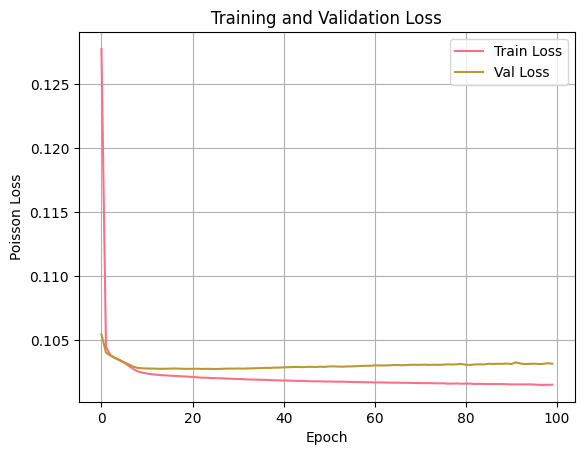

15256/15256 ━━━━━━━━━━━━━━━━━━━━ 5s 352us/step
3814/3814 ━━━━━━━━━━━━━━━━━━━━ 1s 381us/step
2119/2119 ━━━━━━━━━━━━━━━━━━━━ 1s 356us/step
Poisson Neural Network Performance:
Train:      MAE = 0.0945, MSE = 0.0526, Loss = 0.1950
Validation: MAE = 0.0947, MSE = 0.0532, Loss = 0.2004
Test:       MAE = 0.0953, MSE = 0.0535, Loss = 0.2043


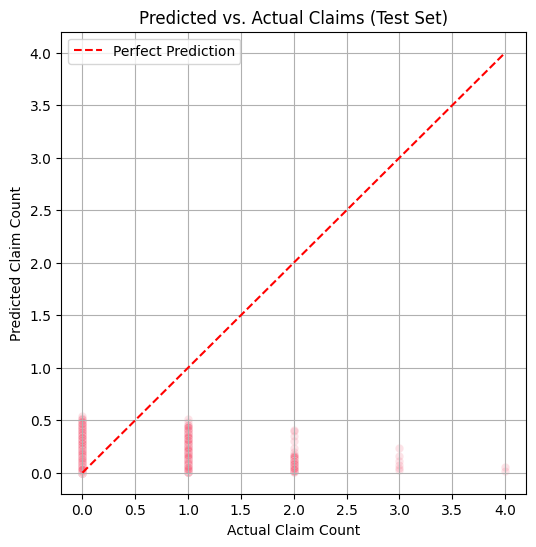

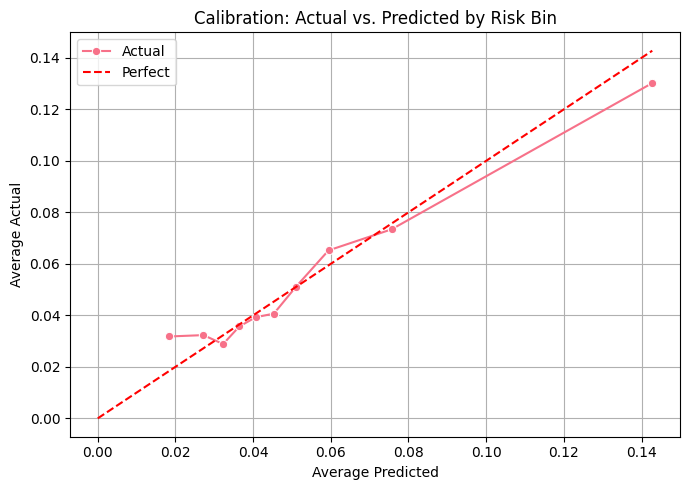

In [149]:
# Set random seed so we get the same outcome everytime we run the cell
np.random.seed(4)
tf.random.set_seed(4)
tf.keras.utils.set_random_seed(4)
random.seed(4)

# Build the model
model = Sequential([
    Input(shape=(X1_train_scaled.shape[1],)),
    Dense(20, activation='relu'),
    Dense(15, activation='relu'),
    Dense(1, activation='exponential')
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.01),
    loss=Poisson()
)

# Set random seed so we get the same outcome everytime we run the cell
np.random.seed(4)
tf.random.set_seed(4)
tf.keras.utils.set_random_seed(4)
random.seed(4)

# Train the model
history = model.fit(
    X1_train_scaled, y_train,
    sample_weight=w_train,
    validation_data=(X1_val_scaled, y_val, w_val),
    epochs=100,
    batch_size=10000,
    verbose=1
)

# Plot training history
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Poisson Loss")
plt.legend()
plt.grid(True)
plt.title("Training and Validation Loss")
plt.show()

# Predict and calculate evaluation metrics
λ_train_nn = model.predict(X1_train_scaled).flatten()
λ_val_nn = model.predict(X1_val_scaled).flatten()
λ_test_nn = model.predict(X1_test_scaled).flatten()

# Compute metrics
mae_train_nn = mean_absolute_error(y_train, λ_train_nn, sample_weight=w_train)
mse_train_nn = mean_squared_error(y_train, λ_train_nn, sample_weight=w_train)
loss_train_nn = weighted_poisson_deviance(y_train, λ_train_nn, w_train)

mae_val_nn = mean_absolute_error(y_val, λ_val_nn, sample_weight=w_val)
mse_val_nn = mean_squared_error(y_val, λ_val_nn, sample_weight=w_val)
loss_val_nn = weighted_poisson_deviance(y_val, λ_val_nn, w_val)

mae_test_nn = mean_absolute_error(y_test, λ_test_nn, sample_weight=w_test)
mse_test_nn = mean_squared_error(y_test, λ_test_nn, sample_weight=w_test)
loss_test_nn = weighted_poisson_deviance(y_test, λ_test_nn, w_test)

# Model evaluation
# --- Print evaluation metrics ---
print("Poisson Neural Network Performance:")
print(f"Train:      MAE = {mae_train_nn:.4f}, MSE = {mse_train_nn:.4f}, Loss = {loss_train_nn:.4f}")
print(f"Validation: MAE = {mae_val_nn:.4f}, MSE = {mse_val_nn:.4f}, Loss = {loss_val_nn:.4f}")
print(f"Test:       MAE = {mae_test_nn:.4f}, MSE = {mse_test_nn:.4f}, Loss = {loss_test_nn:.4f}")

# --- Plot 1: Predicted vs. Actual Scatter ---
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test, y=λ_test_nn, alpha=0.2)
plt.plot([0, max(y_test)], [0, max(y_test)], 'r--', label='Perfect Prediction')
plt.xlabel("Actual Claim Count")
plt.ylabel("Predicted Claim Count")
plt.title("Predicted vs. Actual Claims (Test Set)")
plt.legend()
plt.grid(True)
plt.show()

# --- Plot 2: Binned Calibration Plot ---
df_pred = pd.DataFrame({
    'y_true': y_test,
    'y_pred': λ_test_nn,
    'weight': w_test
})
df_pred['bin'] = pd.qcut(df_pred['y_pred'], q=10, duplicates='drop')

# Compute weighted average per bin
bin_summary = df_pred.groupby('bin', group_keys=False).apply(
    lambda g: pd.Series({
        'avg_actual': np.average(g['y_true'], weights=g['weight']),
        'avg_pred': np.average(g['y_pred'], weights=g['weight'])
    }),
    include_groups=False
).reset_index()

# Plot
plt.figure(figsize=(7, 5))
sns.lineplot(data=bin_summary, x='avg_pred', y='avg_actual', marker='o', label='Actual')
plt.plot([0, bin_summary['avg_pred'].max()], [0, bin_summary['avg_pred'].max()], 'r--', label='Perfect')
plt.xlabel("Average Predicted")
plt.ylabel("Average Actual")
plt.title("Calibration: Actual vs. Predicted by Risk Bin")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()




### Shallow neural network as described in Ferrario et al 2018 (1 hidden layer / 20 neurons

In [142]:
# Set random seed so we get the same outcome everytime we run the cell
np.random.seed(4)
tf.random.set_seed(4)
tf.keras.utils.set_random_seed(4)
random.seed(4)

# Build the model
model = Sequential([
    Input(shape=(X1_train_scaled.shape[1],)),
    Dense(20, activation='relu'),
    Dense(1, activation='exponential')
])

In [143]:
# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.01),
    loss=Poisson()
)

In [144]:
# Set random seed so we get the same outcome everytime we run the cell
np.random.seed(4)
tf.random.set_seed(4)
tf.keras.utils.set_random_seed(4)
random.seed(4)

# Train the model
history = model.fit(
    X1_train_scaled, y_train,
    sample_weight=w_train,
    validation_data=(X1_val_scaled, y_val, w_val),
    epochs=100,
    batch_size=10000,
    verbose=1
)

Epoch 1/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2590 - val_loss: 0.1059
Epoch 2/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1056 - val_loss: 0.1041
Epoch 3/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1045 - val_loss: 0.1038
Epoch 4/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1043 - val_loss: 0.1037
Epoch 5/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1041 - val_loss: 0.1037
Epoch 6/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1041 - val_loss: 0.1036
Epoch 7/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1040 - val_loss: 0.1036
Epoch 8/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1040 - val_loss: 0.1036
Epoch 9/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1039 - val_loss: 0.1035
Epoch 10/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1039 - val_loss: 0.1035
Epoch 11/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1038 - val_loss: 0.1035
Epoch 12/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1

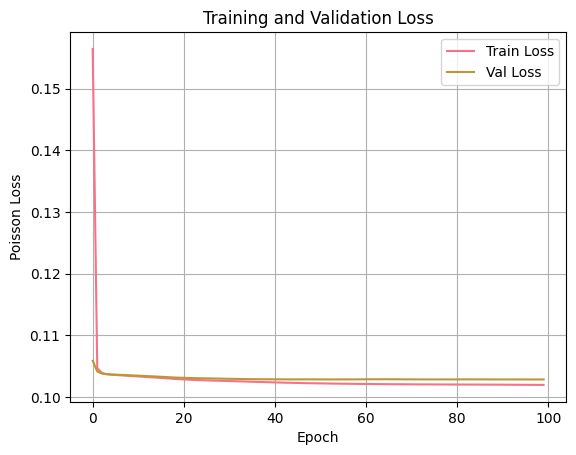

In [145]:
# Plot training history
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Poisson Loss")
plt.legend()
plt.grid(True)
plt.title("Training and Validation Loss")
plt.show()

In [146]:
# Predict and calculate evaluation metrics
λ_train_nn = model.predict(X1_train_scaled).flatten()
λ_val_nn = model.predict(X1_val_scaled).flatten()
λ_test_nn = model.predict(X1_test_scaled).flatten()

# Compute metrics
mae_train_nn = mean_absolute_error(y_train, λ_train_nn, sample_weight=w_train)
mse_train_nn = mean_squared_error(y_train, λ_train_nn, sample_weight=w_train)
loss_train_nn = weighted_poisson_deviance(y_train, λ_train_nn, w_train)

mae_val_nn = mean_absolute_error(y_val, λ_val_nn, sample_weight=w_val)
mse_val_nn = mean_squared_error(y_val, λ_val_nn, sample_weight=w_val)
loss_val_nn = weighted_poisson_deviance(y_val, λ_val_nn, w_val)

mae_test_nn = mean_absolute_error(y_test, λ_test_nn, sample_weight=w_test)
mse_test_nn = mean_squared_error(y_test, λ_test_nn, sample_weight=w_test)
loss_test_nn = weighted_poisson_deviance(y_test, λ_test_nn, w_test)


15256/15256 ━━━━━━━━━━━━━━━━━━━━ 5s 344us/step
3814/3814 ━━━━━━━━━━━━━━━━━━━━ 1s 351us/step
2119/2119 ━━━━━━━━━━━━━━━━━━━━ 1s 349us/step


Poisson Neural Network Performance:
Train:      MAE = 0.0923, MSE = 0.0528, Loss = 0.2017
Validation: MAE = 0.0924, MSE = 0.0532, Loss = 0.2043
Test:       MAE = 0.0929, MSE = 0.0535, Loss = 0.2076


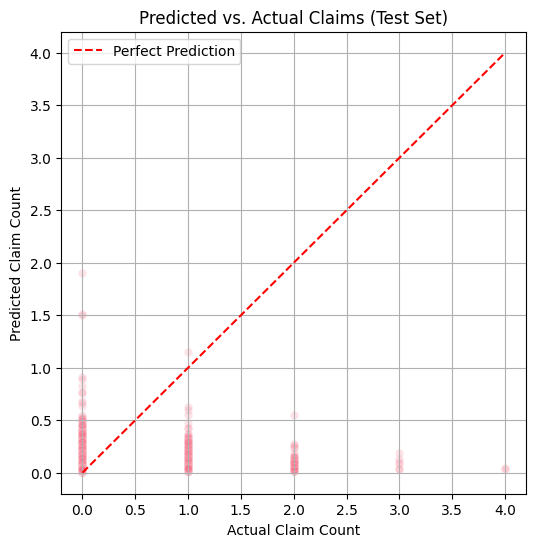

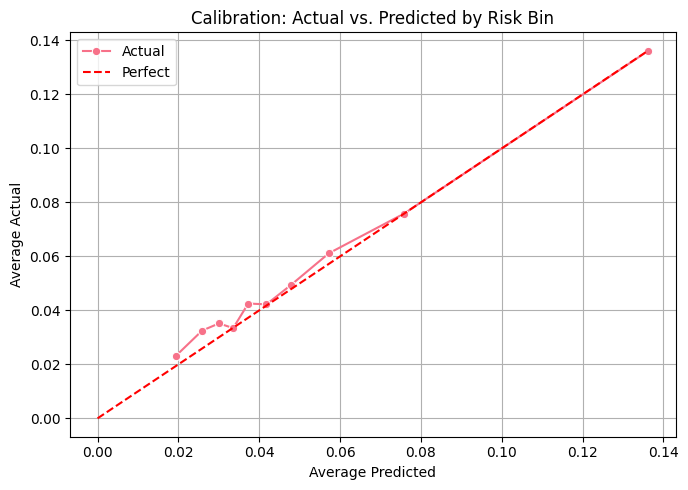

In [147]:
# Model evaluation
# --- Print evaluation metrics ---
print("Poisson Neural Network Performance:")
print(f"Train:      MAE = {mae_train_nn:.4f}, MSE = {mse_train_nn:.4f}, Loss = {loss_train_nn:.4f}")
print(f"Validation: MAE = {mae_val_nn:.4f}, MSE = {mse_val_nn:.4f}, Loss = {loss_val_nn:.4f}")
print(f"Test:       MAE = {mae_test_nn:.4f}, MSE = {mse_test_nn:.4f}, Loss = {loss_test_nn:.4f}")

# --- Plot 1: Predicted vs. Actual Scatter ---
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test, y=λ_test_nn, alpha=0.2)
plt.plot([0, max(y_test)], [0, max(y_test)], 'r--', label='Perfect Prediction')
plt.xlabel("Actual Claim Count")
plt.ylabel("Predicted Claim Count")
plt.title("Predicted vs. Actual Claims (Test Set)")
plt.legend()
plt.grid(True)
plt.show()

# --- Plot 2: Binned Calibration Plot ---
df_pred = pd.DataFrame({
    'y_true': y_test,
    'y_pred': λ_test_nn,
    'weight': w_test
})
df_pred['bin'] = pd.qcut(df_pred['y_pred'], q=10, duplicates='drop')

# Compute weighted average per bin
bin_summary = df_pred.groupby('bin', group_keys=False).apply(
    lambda g: pd.Series({
        'avg_actual': np.average(g['y_true'], weights=g['weight']),
        'avg_pred': np.average(g['y_pred'], weights=g['weight'])
    }),
    include_groups=False
).reset_index()

# Plot
plt.figure(figsize=(7, 5))
sns.lineplot(data=bin_summary, x='avg_pred', y='avg_actual', marker='o', label='Actual')
plt.plot([0, bin_summary['avg_pred'].max()], [0, bin_summary['avg_pred'].max()], 'r--', label='Perfect')
plt.xlabel("Average Predicted")
plt.ylabel("Average Actual")
plt.title("Calibration: Actual vs. Predicted by Risk Bin")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


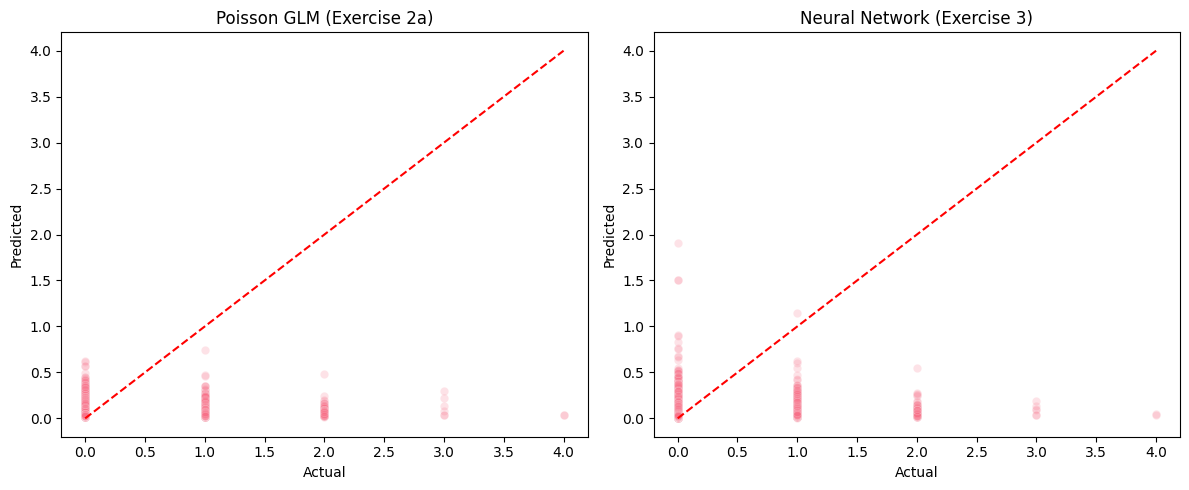

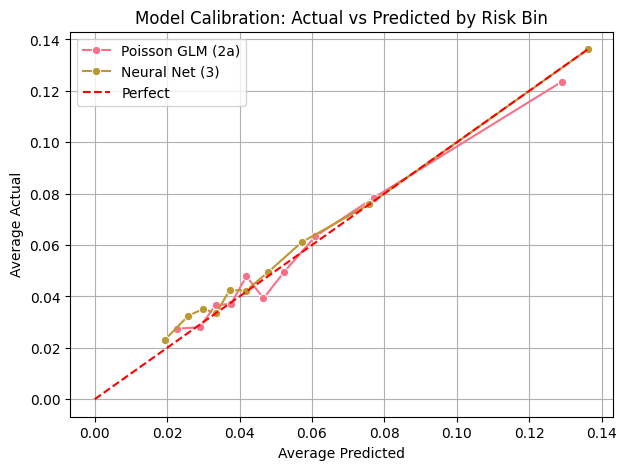

Comparison of Poisson GLM (2a) vs Neural Network (3) on Test Set
          Metric  Poisson GLM (2a)  Neural Net (3)  Relative Improvement (%)
             MAE            0.0959          0.0929                    3.1018
             MSE            0.0536          0.0535                    0.2827
Poisson Deviance            0.2048          0.2076                   -1.3504


In [148]:
# Set predictions
λ_test_glm = λ_test_original     # Predictions from Poisson GLM (Exercise 2a)
λ_test_nn = λ_test_nn            # Predictions from Neural Network (Exercise 3)
y_true_test = y_test             # True labels

# --- Side-by-side scatter plots ---
plt.figure(figsize=(12, 5))

# Left: Poisson GLM (2a)
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_true_test, y=λ_test_glm, alpha=0.2)
plt.plot([0, max(y_true_test)], [0, max(y_true_test)], 'r--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Poisson GLM (Exercise 2a)")

# Right: Neural Network (3)
plt.subplot(1, 2, 2)
sns.scatterplot(x=y_true_test, y=λ_test_nn, alpha=0.2)
plt.plot([0, max(y_true_test)], [0, max(y_true_test)], 'r--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Neural Network (Exercise 3)")

plt.tight_layout()
plt.show()

# --- Calibration Plot ---
def make_binned_comparison(y_true, y_pred, weights, label):
    df = pd.DataFrame({
        'y_true': y_true,
        'y_pred': y_pred,
        'weight': weights
    })
    df['bin'] = pd.qcut(df['y_pred'], q=10, duplicates='drop')
    grouped = df.groupby('bin', group_keys=False).apply(
        lambda g: pd.Series({
            'avg_actual': np.average(g['y_true'], weights=g['weight']),
            'avg_pred': np.average(g['y_pred'], weights=g['weight'])
        }),
        include_groups=False
    )
    grouped['model'] = label
    return grouped.reset_index()

# Create summaries
binned_glm = make_binned_comparison(y_test, λ_test_glm, w_test, label='Poisson GLM (2a)')
binned_nn = make_binned_comparison(y_test, λ_test_nn, w_test, label='Neural Net (3)')

# Combine and plot
binned_all = pd.concat([binned_glm, binned_nn])

plt.figure(figsize=(7, 5))
sns.lineplot(data=binned_all, x='avg_pred', y='avg_actual', hue='model', marker='o')
plt.plot([0, binned_all['avg_pred'].max()], [0, binned_all['avg_pred'].max()], 'r--', label='Perfect')
plt.xlabel("Average Predicted")
plt.ylabel("Average Actual")
plt.title("Model Calibration: Actual vs Predicted by Risk Bin")
plt.grid(True)
plt.legend()
plt.show()

# --- Final Metric Comparison Table ---
comparison_df = pd.DataFrame({
    "Metric": ["MAE", "MSE", "Poisson Deviance"],
    "Poisson GLM (2a)": [
        mae_test_original,
        mse_test_original,
        loss_test_original
    ],
    "Neural Net (3)": [
        mae_test_nn,
        mse_test_nn,
        loss_test_nn
    ]
})

# Compute relative improvement (%)
comparison_df["Relative Improvement (%)"] = (
    (comparison_df["Poisson GLM (2a)"] - comparison_df["Neural Net (3)"])
    / comparison_df["Poisson GLM (2a)"]
) * 100

# Print results
print("Comparison of Poisson GLM (2a) vs Neural Network (3) on Test Set")
print(comparison_df.round(4).to_string(index=False))


### (BONUS) Hyperparameter Tuning

In [84]:
def build_model(hp):
    model = keras.Sequential()

    model.add(layers.Input(shape=(X1_train_scaled.shape[1],)))

    for i in range(hp.Int("num_layers", 1, 2)):
        model.add(layers.Dense(
            units=hp.Int(f"units_{i}", min_value=32, max_value=128, step=32),
            activation="relu",
            kernel_regularizer=keras.regularizers.l2(1e-05)
        ))

        if hp.Boolean(f"use_bn_{i}"):
            model.add(layers.BatchNormalization())

        if hp.Boolean(f"use_dropout_{i}"):
            model.add(layers.Dropout(rate=hp.Float(f"dropout_rate_{i}", 0.1, 0.3, step=0.1)))

    model.add(layers.Dense(1, activation="exponential"))

    model.compile(
        optimizer=keras.optimizers.Adam(
            learning_rate=hp.Float("lr", min_value=1e-3, max_value=5e-3, sampling="log")
        ),
        loss="poisson",
        metrics=["mae", "mse"]
    )

    return model


In [85]:
# Set all random seeds
tf.random.set_seed(4)
tf.keras.utils.set_random_seed(4)

tuner = kt.Hyperband(
    build_model,
    objective="val_loss",
    max_epochs=50,
    factor=3,
    directory="keras_tuner_dir",
    project_name="poisson_nn_tuning_restricted",
    overwrite=True
)

# Early stopping callback
stop_early = keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)


tuner.search(
    X1_train_scaled, y_train,
    validation_data=(X1_val_scaled, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[stop_early],
    verbose=1
)


Trial 90 Complete [00h 02m 55s]
val_loss: 0.16124986112117767

Best val_loss So Far: 0.1606455296278
Total elapsed time: 01h 59m 16s


In [86]:
# Set all random seeds
tf.random.set_seed(4)
tf.keras.utils.set_random_seed(4)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best hyperparameters:")
for k in best_hps.values.keys():
    print(f"{k}: {best_hps.get(k)}")

# Build best model
best_model = tuner.hypermodel.build(best_hps)

# Train best model
history = best_model.fit(
    X1_train_scaled, y_train,
    validation_data=(X1_val_scaled, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[stop_early],
    verbose=1
)


Best hyperparameters:
num_layers: 1
units_0: 96
use_bn_0: False
use_dropout_0: False
lr: 0.001065325662450247
units_1: 96
use_bn_1: False
use_dropout_1: True
dropout_rate_1: 0.2
dropout_rate_0: 0.2
tuner/epochs: 50
tuner/initial_epoch: 17
tuner/bracket: 3
tuner/round: 3
tuner/trial_id: 0047
Epoch 1/50
15256/15256 ━━━━━━━━━━━━━━━━━━━━ 11s 716us/step - loss: 0.1790 - mae: 0.0851 - mse: 0.0474 - val_loss: 0.1623 - val_mae: 0.0749 - val_mse: 0.0418
Epoch 2/50
15256/15256 ━━━━━━━━━━━━━━━━━━━━ 11s 748us/step - loss: 0.1632 - mae: 0.0749 - mse: 0.0416 - val_loss: 0.1615 - val_mae: 0.0726 - val_mse: 0.0417
Epoch 3/50
15256/15256 ━━━━━━━━━━━━━━━━━━━━ 12s 794us/step - loss: 0.1610 - mae: 0.0737 - mse: 0.0411 - val_loss: 0.1618 - val_mae: 0.0781 - val_mse: 0.0418
Epoch 4/50
15256/15256 ━━━━━━━━━━━━━━━━━━━━ 11s 745us/step - loss: 0.1625 - mae: 0.0746 - mse: 0.0415 - val_loss: 0.1628 - val_mae: 0.0839 - val_mse: 0.0421
Epoch 5/50
15256/15256 ━━━━━━━━━━━━━━━━━━━━ 11s 738us/step - loss: 0.1599 - mae:

In [88]:
# Set all random seeds
tf.random.set_seed(4)
tf.keras.utils.set_random_seed(4)
# Predict on test set
λ_test_nn_restricted = best_model.predict(X1_test_scaled).flatten()

2119/2119 ━━━━━━━━━━━━━━━━━━━━ 1s 382us/step


In [ ]:
# best_hps.values unrestricted
# # {'num_layers': 3,
#  'units_0': 256,
#  'use_bn_0': False,
#  'use_dropout_0': True,
#  'lr': 0.0003807736827673576,
#  'units_1': 128,
#  'use_bn_1': True,
#  'use_dropout_1': False,
#  'units_2': 64,
#  'use_bn_2': True,
#  'use_dropout_2': True,
#  'dropout_rate_0': 0.2,
#  'dropout_rate_1': 0.2,
#  'dropout_rate_2': 0.4,
#  'tuner/epochs': 7,
#  'tuner/initial_epoch': 3,
#  'tuner/bracket': 2,
#  'tuner/round': 1,
#  'tuner/trial_id': '0011'}


In [87]:
# best values from the restricted model
# best_hps.values
# {'num_layers': 1,
#  'units_0': 96,
#  'use_bn_0': False,
#  'use_dropout_0': False,
#  'lr': 0.001065325662450247,
#  'units_1': 96,
#  'use_bn_1': False,
#  'use_dropout_1': True,
#  'dropout_rate_1': 0.2,
#  'dropout_rate_0': 0.2,
#  'tuner/epochs': 50,
#  'tuner/initial_epoch': 17,
#  'tuner/bracket': 3,
#  'tuner/round': 3,
#  'tuner/trial_id': '0047'}

{'num_layers': 1,
 'units_0': 96,
 'use_bn_0': False,
 'use_dropout_0': False,
 'lr': 0.001065325662450247,
 'units_1': 96,
 'use_bn_1': False,
 'use_dropout_1': True,
 'dropout_rate_1': 0.2,
 'dropout_rate_0': 0.2,
 'tuner/epochs': 50,
 'tuner/initial_epoch': 17,
 'tuner/bracket': 3,
 'tuner/round': 3,
 'tuner/trial_id': '0047'}

In [155]:
# Set all random seeds
tf.random.set_seed(4)
tf.keras.utils.set_random_seed(4)

# Define model predictions
λ_test_glm = λ_test_original               # GLM (Exercise 2a)
λ_test_nn_baseline = λ_test_nn            # Baseline NN
λ_test_nn_tuned = best_model.predict(X1_test_scaled).flatten()  # Tuned NN
y_true_test = y_test


2119/2119 ━━━━━━━━━━━━━━━━━━━━ 1s 357us/step


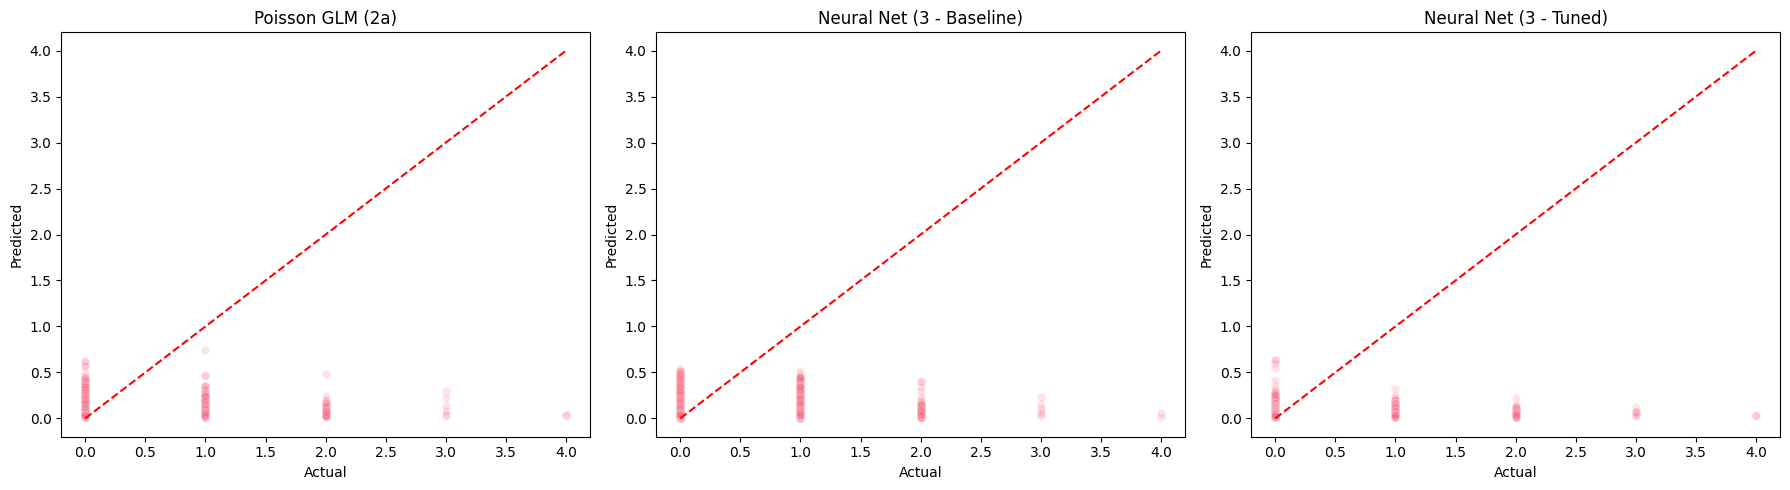

In [156]:
# --- Scatter plots ---
plt.figure(figsize=(18, 5))

# GLM
plt.subplot(1, 3, 1)
sns.scatterplot(x=y_true_test, y=λ_test_glm, alpha=0.2)
plt.plot([0, max(y_true_test)], [0, max(y_true_test)], 'r--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Poisson GLM (2a)")

# Baseline NN
plt.subplot(1, 3, 2)
sns.scatterplot(x=y_true_test, y=λ_test_nn_baseline, alpha=0.2)
plt.plot([0, max(y_true_test)], [0, max(y_true_test)], 'r--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Neural Net (3 - Baseline)")

# Tuned NN
plt.subplot(1, 3, 3)
sns.scatterplot(x=y_true_test, y=λ_test_nn_tuned, alpha=0.2)
plt.plot([0, max(y_true_test)], [0, max(y_true_test)], 'r--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Neural Net (3 - Tuned)")

plt.tight_layout()
plt.show()


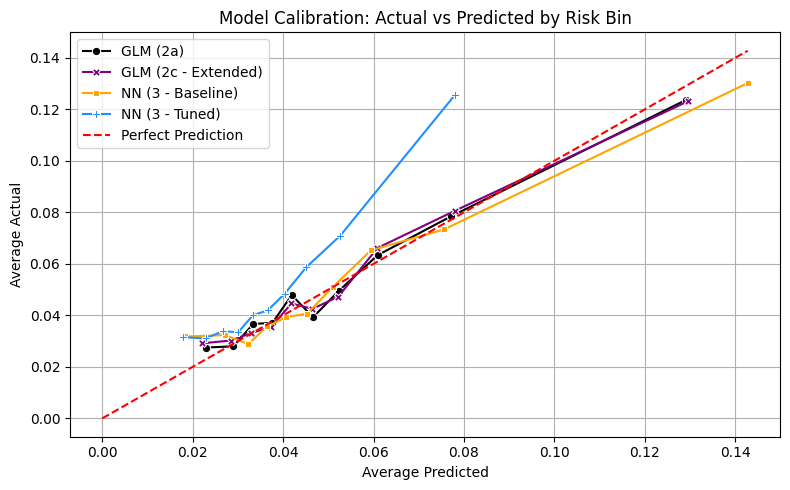

In [157]:
# Define distinct colors and markers manually
palette = {
    'GLM (2a)': 'black',
    'GLM (2c - Extended)': 'purple',
    'NN (3 - Baseline)': 'orange',
    'NN (3 - Tuned)': 'dodgerblue'
}
markers = {
    'GLM (2a)': 'o',
    'GLM (2c - Extended)': 's',
    'NN (3 - Baseline)': 'D',
    'NN (3 - Tuned)': '^'
}

# --- Calibration Plot including GLM (2c) ---
binned_glm = make_binned_comparison(y_test, λ_test_glm, w_test, label='GLM (2a)')
binned_glm_ext = make_binned_comparison(y_test, λ_test_extended, w_test, label='GLM (2c - Extended)')
binned_baseline = make_binned_comparison(y_test, λ_test_nn_baseline, w_test, label='NN (3 - Baseline)')
binned_tuned = make_binned_comparison(y_test, λ_test_nn_tuned, w_test, label='NN (3 - Tuned)')

# Combine all models
binned_all = pd.concat([binned_glm, binned_glm_ext, binned_baseline, binned_tuned])

# Plot
plt.figure(figsize=(8, 5))
sns.lineplot(
    data=binned_all,
    x='avg_pred',
    y='avg_actual',
    hue='model',
    style='model',
    markers=True,
    dashes=False,
    palette=palette
)
plt.plot(
    [0, binned_all['avg_pred'].max()],
    [0, binned_all['avg_pred'].max()],
    'r--',
    label='Perfect Prediction'
)
plt.xlabel("Average Predicted")
plt.ylabel("Average Actual")
plt.title("Model Calibration: Actual vs Predicted by Risk Bin")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [95]:
# --- Metric Comparison ---
mae_test_nn_tuned = weighted_mae(y_test, λ_test_nn_tuned, w_test)
mse_test_nn_tuned = weighted_mse(y_test, λ_test_nn_tuned, w_test)
loss_test_nn_tuned = weighted_poisson_deviance(y_test, λ_test_nn_tuned, w_test)


In [96]:
comparison_df = pd.DataFrame({
    "Metric": ["MAE", "MSE", "Poisson Deviance"],
    "GLM (2a)": [
        mae_test_original,
        mse_test_original,
        loss_test_original
    ],
    "NN (3 - Baseline)": [
        mae_test_nn,
        mse_test_nn,
        loss_test_nn
    ],
    "NN (3 - Tuned)": [
        mae_test_nn_tuned,
        mse_test_nn_tuned,
        loss_test_nn_tuned
    ]
})

comparison_df["Improvement vs GLM (%)"] = (
    (comparison_df["GLM (2a)"] - comparison_df["NN (3 - Tuned)"])
    / comparison_df["GLM (2a)"]
) * 100

print("Comparison of GLM vs Baseline NN vs Tuned NN on Test Set")
print(comparison_df.round(4).to_string(index=False))

Comparison of GLM vs Baseline NN vs Tuned NN on Test Set
          Metric  GLM (2a)  NN (3 - Baseline)  NN (3 - Tuned)  Improvement vs GLM (%)
             MAE    0.0959             0.0994          0.0851                 11.3126
             MSE    0.0536             0.0535          0.0539                 -0.4378
Poisson Deviance    0.2048             0.1943          0.2319                -13.2341


### (BONUS) Grid Search Regularization

In [150]:
# Define grid of L2 regularization strengths to test
l2_values = [1e-5, 1e-4, 1e-3, 1e-2]


In [152]:
results = []

for l2_strength in l2_values:
    tf.keras.utils.set_random_seed(4)
    tf.random.set_seed(4)

    # Build model
    model = Sequential([
        Input(shape=(X1_train_scaled.shape[1],)),
        Dense(20, activation='relu', kernel_regularizer=l2(l2_strength)),
        Dense(20, activation='relu', kernel_regularizer=l2(l2_strength)),
        Dense(1, activation='exponential', kernel_regularizer=l2(l2_strength))
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.01),
        loss=Poisson(),
        metrics=["mae", "mse"]
    )

    # Train
    history = model.fit(
        X1_train_scaled, y_train,
        sample_weight=w_train,
        validation_data=(X1_val_scaled, y_val, w_val),
        epochs=100,
        batch_size=10000,
        verbose=0
    )

    # Evaluate
    λ_test = model.predict(X1_test_scaled).flatten()
    mae = weighted_mae(y_test, λ_test, w_test)
    mse = weighted_mse(y_test, λ_test, w_test)
    loss = weighted_poisson_deviance(y_test, λ_test, w_test)
    val_loss = min(history.history["val_loss"])

    results.append({
        "l2": l2_strength,
        "val_loss": val_loss,
        "mae": mae,
        "mse": mse,
        "poisson": loss
    })


2119/2119 ━━━━━━━━━━━━━━━━━━━━ 1s 374us/step
2119/2119 ━━━━━━━━━━━━━━━━━━━━ 1s 391us/step
2119/2119 ━━━━━━━━━━━━━━━━━━━━ 1s 361us/step
2119/2119 ━━━━━━━━━━━━━━━━━━━━ 1s 364us/step


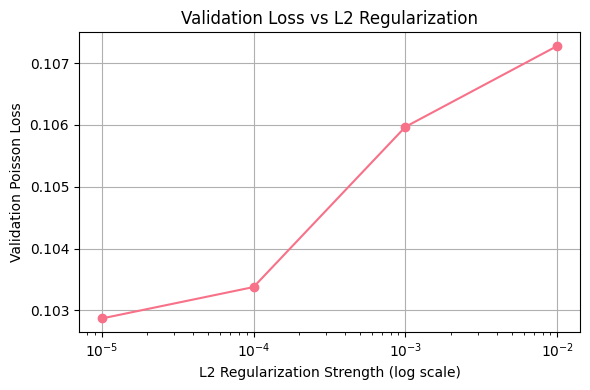

In [153]:
# Plot the loss across the different models
df_l2 = pd.DataFrame(results)

plt.figure(figsize=(6, 4))
plt.plot(df_l2["l2"], df_l2["val_loss"], marker='o')
plt.xscale("log")
plt.xlabel("L2 Regularization Strength (log scale)")
plt.ylabel("Validation Poisson Loss")
plt.title("Validation Loss vs L2 Regularization")
plt.grid(True)
plt.tight_layout()
plt.show()


In [154]:
# Select best L2 based on validation loss
best_l2_row = df_l2.loc[df_l2["val_loss"].idxmin()]
best_l2_value = best_l2_row["l2"]

print("Best L2 value:", best_l2_value)

# Final comparison
comparison_df = pd.DataFrame({
    "Metric": ["MAE", "MSE", "Poisson Deviance"],
    "GLM (2a)": [
        mae_test_original,
        mse_test_original,
        loss_test_original
    ],
    "NN (untuned)": [
        mae_test_nn,
        mse_test_nn,
        loss_test_nn
    ],
    f"NN (L2={best_l2_value:.0e})": [
        best_l2_row["mae"],
        best_l2_row["mse"],
        best_l2_row["poisson"]
    ]
})

comparison_df["Improvement vs GLM (%)"] = (
    (comparison_df["GLM (2a)"] - comparison_df[f"NN (L2={best_l2_value:.0e})"])
    / comparison_df["GLM (2a)"]
) * 100

print("Test Set Comparison")
print(comparison_df.round(4).to_string(index=False))


Best L2 value: 1e-05
Test Set Comparison
          Metric  GLM (2a)  NN (untuned)  NN (L2=1e-05)  Improvement vs GLM (%)
             MAE    0.0959        0.0953         0.0947                  1.2655
             MSE    0.0536        0.0535         0.0533                  0.6447
Poisson Deviance    0.2048        0.2043         0.2025                  1.1136
